<a href="https://colab.research.google.com/github/Walden10/Tourism-Forecasting/blob/main/Forecast%20_India.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# ML - Autoregressive and Search Data - India

This notebook contains all the code to create and compile multiple ML models to predict tourism volumes for Italy. The models include the following:

1. Random Forest
2. Support Vector Regression
3. XG Boost
4. Deep Learning Model (Basic one for now but will do the LSTM later)

## Mounting Gdrive

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


First let's import the dataset

In [ ]:
# import the necessary pre-requisite libraries
# Regression Example With Boston Dataset: Standardized and Wider
import pandas as pd
import numpy as np
import time
import matplotlib.pyplot as plt
import seaborn as sns


from keras.models import Sequential
from keras.layers import Dense
from keras.wrappers.scikit_learn import KerasRegressor
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


In [ ]:
def get_mda(y, yhat):
    
    a = np.sign(np.diff(y))
    b = np.sign(np.diff(yhat))
    return np.sum(a == b)/a.shape[0]

# Data Preparation

In [ ]:
# import the file
df = pd.read_excel('/content/gdrive/My Drive/Datasets/ArrivalDatapre2019.xlsx')
gtrend = pd.read_excel('/content/gdrive/My Drive/Datasets/India-Gtrendpre2019.xlsx')


# set the correct date time format
df['Date'] = pd.to_datetime(df['Date'], format="%d/%m/%Y")
gtrend['Month'] = pd.to_datetime(gtrend['Month'], format='%Y-%m')

# set date as the index
df.set_index("Date", inplace=True)
gtrend.set_index('Month', inplace=True)



In [ ]:
# inspect the dataset to see if its correct
df.head()

,Total tourist arrivals,Italy,Germany,India
Date,,,,
2004-01-01,61861,15478,5869,994
2004-02-01,59692,16181,6446,786
2004-03-01,63855,17540,7143,788
2004-04-01,55396,12843,6195,871
2004-05-01,42197,6536,6788,1318


In [ ]:
gtrend.head()

,best resort in maldives,flights to maldives,honeymoon packages in maldives,maldives airport,maldives beach,maldives family trip,maldives honeymoon,maldives hotels,maldives resort,maldives visa,maldives water villa,maldives weather,male maldives,mumbai to maldives,sun island resort maldives,delhi to maldives flight
Month,,,,,,,,,,,,,,,,
2004-01-01,0,0,0,0,0,0,32,48,53,0,0,0,100,100,0,0
2004-02-01,0,0,0,0,40,0,0,48,81,0,0,95,0,0,0,0
2004-03-01,0,0,0,0,100,0,0,91,34,0,0,0,0,0,0,0
2004-04-01,0,38,0,0,0,0,31,23,77,0,0,91,32,0,0,0
2004-05-01,0,0,0,0,0,0,27,20,44,0,0,0,27,0,0,0


In [ ]:
print('Our dataframe is',  df.shape,  'Our google trend data is',  gtrend.shape)

Our dataframe is (192, 4) Our google trend data is (192, 16)


So we know that we have 192 records, and among them we have 4 seperate arrival data, and 16 keywords.

Since this file is going to be making forecasts only for Italy and none other, lets cut every other arrival data from the df, and then join the dataframe with the gtrend data.

## Visualization

In [ ]:
# set the seaborn theme
sns.set_theme(style='darkgrid', palette='winter_r')

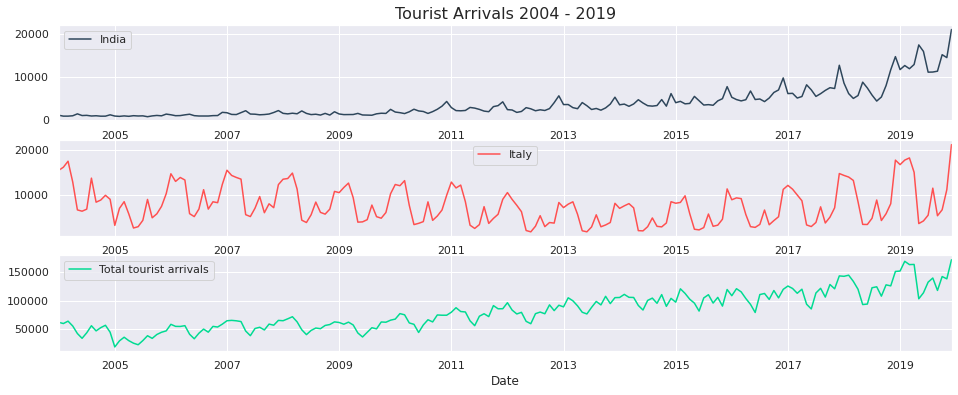

In [ ]:
plt.subplot(311)
ax = df['India'].plot(figsize=(16, 6), legend=True, color='#2e465b')

# change title parameters
ax.set_title('Tourist Arrivals 2004 - 2019', fontsize=16) # set the title

plt.subplot(312)
ax = df['Italy'].plot(figsize=(16, 6), legend=True, color='#ff5050')
plt.subplot(313)
ax = df['Total tourist arrivals'].plot(figsize=(16, 6), legend=True)




Visualize the text data

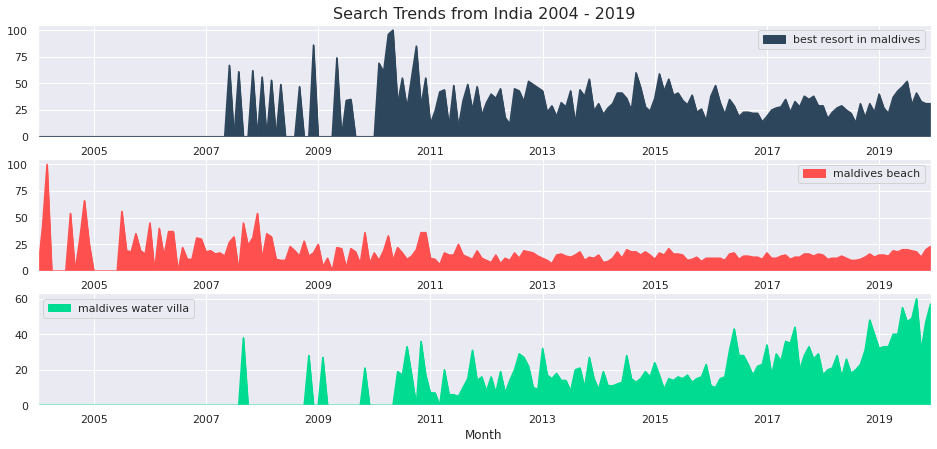

In [ ]:
plt.subplot(311)
ax = gtrend['best resort in maldives'].plot(figsize=(16, 7), legend=True, color='#2e465b', kind='area')

# change title parameters
ax.set_title('Search Trends from India 2004 - 2019', fontsize=16) # set the title

plt.subplot(312)
ax = gtrend['maldives beach'].plot(figsize=(16, 7), legend=True, color='#ff5050', kind='area')
plt.subplot(313)
ax = gtrend['maldives water villa'].plot(figsize=(16, 7), legend=True, kind='area')


In [ ]:
# we will be using this same set of code for all of the various countries

# specify the country i need
country = 'India'

# drop any columns not in country
for column in df:
    if column not in country:
        del df[column]

# join the two files on the index
main_df = df.join(gtrend)

In [ ]:
main_df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 192 entries, 2004-01-01 to 2019-12-01
Data columns (total 17 columns):
 #   Column                          Non-Null Count  Dtype
---  ------                          --------------  -----
 0   India                           192 non-null    int64
 1   best resort in maldives         192 non-null    int64
 2   flights to maldives             192 non-null    int64
 3   honeymoon packages in maldives  192 non-null    int64
 4   maldives airport                192 non-null    int64
 5   maldives beach                  192 non-null    int64
 6   maldives family trip            192 non-null    int64
 7   maldives honeymoon              192 non-null    int64
 8   maldives hotels                 192 non-null    int64
 9   maldives resort                 192 non-null    int64
 10  maldives visa                   192 non-null    int64
 11  maldives water villa            192 non-null    int64
 12  maldives weather                192 non-null 

Forecasting and time-series data work best with stationary data. So here we'll test for stationarity of data and if not, induce statinoarity

## Visualization

## Lag Creation

Since we wish to make predictions using 'past' data, then we'll have to create autoregressive lags. Lets make 12 Lags for now.

In [ ]:
#create an empty dataframe to add our lagged variables (X train set)

lagged = pd.DataFrame()  

# take Italy values to train target
target = main_df['India'].values


number_lags = 12
for lag in range(1, number_lags + 1):
  for column in main_df:
    lagged[str(column) + 'lag' + str(lag)] = main_df[column].shift(lag)


# copy into a new dataframe to get a de-fragmented newframe
lagged = lagged.copy()

# add the non-lagged target value back into the dataframe
lagged['India'] = target

# drop na variables in the lagtrend
lagged.dropna(inplace=True)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:12: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`
  if sys.path[0] == '':


In [ ]:
lagged.head()

,Indialag1,best resort in maldiveslag1,flights to maldiveslag1,honeymoon packages in maldiveslag1,maldives airportlag1,maldives beachlag1,maldives family triplag1,maldives honeymoonlag1,maldives hotelslag1,maldives resortlag1,...,maldives hotelslag12,maldives resortlag12,maldives visalag12,maldives water villalag12,maldives weatherlag12,male maldiveslag12,mumbai to maldiveslag12,sun island resort maldiveslag12,delhi to maldives flightlag12,India
Date,,,,,,,,,,,,,,,,,,,,,
2005-01-01,1096.0,0.0,52.0,100.0,63.0,26.0,0.0,64.0,63.0,35.0,...,48.0,53.0,0.0,0.0,0.0,100.0,100.0,0.0,0.0,807
2005-02-01,807.0,0.0,25.0,0.0,60.0,0.0,0.0,0.0,15.0,0.0,...,48.0,81.0,0.0,0.0,95.0,0.0,0.0,0.0,0.0,733
2005-03-01,733.0,0.0,0.0,0.0,0.0,0.0,0.0,21.0,15.0,0.0,...,91.0,34.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,843
2005-04-01,843.0,0.0,22.0,0.0,0.0,0.0,0.0,18.0,39.0,44.0,...,23.0,77.0,0.0,0.0,91.0,32.0,0.0,0.0,0.0,746
2005-05-01,746.0,0.0,25.0,0.0,0.0,0.0,0.0,20.0,15.0,17.0,...,20.0,44.0,0.0,0.0,0.0,27.0,0.0,0.0,0.0,891


In [ ]:
lagged.tail()

,Indialag1,best resort in maldiveslag1,flights to maldiveslag1,honeymoon packages in maldiveslag1,maldives airportlag1,maldives beachlag1,maldives family triplag1,maldives honeymoonlag1,maldives hotelslag1,maldives resortlag1,...,maldives hotelslag12,maldives resortlag12,maldives visalag12,maldives water villalag12,maldives weatherlag12,male maldiveslag12,mumbai to maldiveslag12,sun island resort maldiveslag12,delhi to maldives flightlag12,India
Date,,,,,,,,,,,,,,,,,,,,,
2019-08-01,11035.0,52.0,19.0,21.0,34.0,20.0,7.0,36.0,15.0,43.0,...,7.0,18.0,13.0,20.0,17.0,11.0,26.0,7.0,13.0,11067
2019-09-01,11067.0,30.0,14.0,10.0,37.0,19.0,18.0,33.0,14.0,37.0,...,9.0,26.0,18.0,23.0,19.0,12.0,31.0,13.0,25.0,11265
2019-10-01,11265.0,41.0,14.0,14.0,33.0,18.0,7.0,32.0,15.0,37.0,...,9.0,25.0,16.0,31.0,18.0,13.0,36.0,11.0,25.0,15110
2019-11-01,15110.0,33.0,13.0,11.0,28.0,13.0,7.0,25.0,11.0,29.0,...,9.0,30.0,21.0,48.0,20.0,15.0,38.0,14.0,20.0,14430
2019-12-01,14430.0,31.0,17.0,20.0,34.0,20.0,14.0,37.0,15.0,37.0,...,10.0,27.0,20.0,40.0,23.0,14.0,35.0,14.0,19.0,20983


We will also be building a dataframe that includes only lagged values of the target, so we can compare between performance of both purely autoregressive, as well as with predictors (keywords).

In [ ]:
lagged.shape

(180, 205)

## Unit-Root Stationarity

Forecasting works significantly better when data is stationarity. So we'll need to induce stationarity first before we do anything else.

In [ ]:
# first we check for stationarity

from statsmodels.tsa.stattools import adfuller, kpss

for x in ['India']:
    adf_pval = adfuller(lagged[x], regression="nc")[1]
    print(x)
    print(f"ADF, p-value: {adf_pval}")
    if adf_pval > 0.05:
        print('The data is non-stationary as per ADF')
    else:
        print('The data is stationary as per ADF')
    kpss_stat, kpss_pval, lags, crit_vals = kpss(lagged[x])
    print(f"KPSS, p-value: {kpss_pval}")
    print('-----------------------------')
    

/usr/local/lib/python3.7/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


India
ADF, p-value: 0.9979575085356236
The data is non-stationary as per ADF
KPSS, p-value: 0.01
-----------------------------


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1685: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1709: InterpolationWarning: p-value is smaller than the indicated p-value
  warn("p-value is smaller than the indicated p-value", InterpolationWarning)


In [ ]:
lagged.shape

(180, 205)

In [ ]:
# to induce stationarity, we will do differencing for the whole dataset 
lag_diff = lagged.diff()

# differencing creates a missing number in the first row - so we'll need to remove the first na row
lag_diff.dropna(inplace=True)

Now check for stationarity after differencing

In [ ]:
for x in ['India']:
    print(x)
    adf_pval = adfuller(lag_diff[x], regression="nc")[1]
    print("ADF, p-value:", adf_pval)
    if adf_pval > 0.05:
        print('The data is non-stationary as per adf')
    else:
        print("The data is stationary as per adf")
    kpss_stat, kpss_pval, lags, crit_vals = kpss(lag_diff[x])
    print("KPSS, p-value:", kpss_pval)
    print("---------------------------")

India
ADF, p-value: 0.8002271449527689
The data is non-stationary as per adf
KPSS, p-value: 0.04794784565924856
---------------------------


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1685: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)


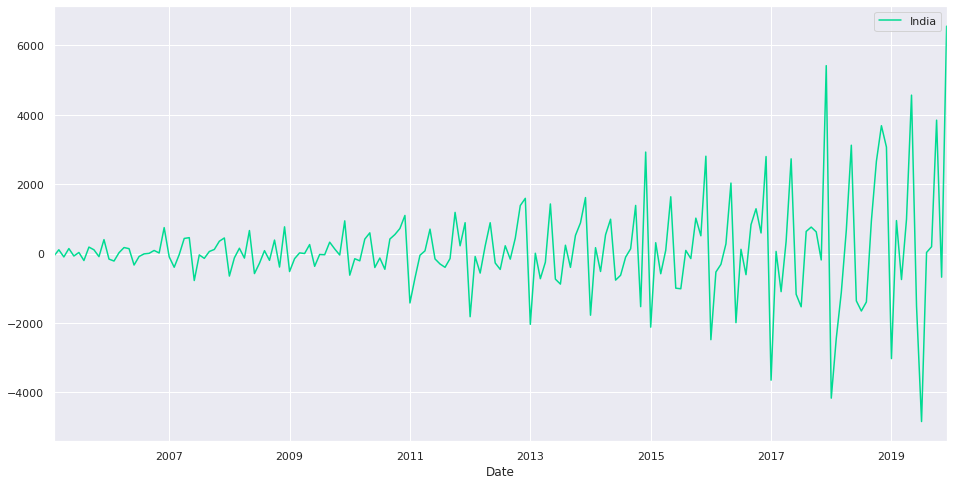

In [ ]:
lag_diff['India'].plot(figsize=(16, 8), legend=True)

In [ ]:
print(lag_diff.shape)

(179, 205)


In [ ]:
# to induce stationarity, we will do differencing for the whole dataset 
lag_diff = lag_diff.diff()

# differencing creates a missing number in the first row - so we'll need to remove the first na row
lag_diff.dropna(inplace=True)

In [ ]:
for x in ['India']:
    print(x)
    adf_pval = adfuller(lag_diff[x], regression="nc")[1]
    print("ADF, p-value:", adf_pval)
    if adf_pval > 0.05:
        print('The data is non-stationary as per adf')
    else:
        print("The data is stationary as per adf")
    kpss_stat, kpss_pval, lags, crit_vals = kpss(lag_diff[x])
    print("KPSS, p-value:", kpss_pval)
    print("---------------------------")

India
ADF, p-value: 4.719432134476926e-08
The data is stationary as per adf
KPSS, p-value: 0.1
---------------------------


/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1685: FutureWarning: The behavior of using lags=None will change in the next release. Currently lags=None is the same as lags='legacy', and so a sample-size lag length is used. After the next release, the default will change to be the same as lags='auto' which uses an automatic lag length selection method. To silence this warning, either use 'auto' or 'legacy'
  warn(msg, FutureWarning)
/usr/local/lib/python3.7/dist-packages/statsmodels/tsa/stattools.py:1711: InterpolationWarning: p-value is greater than the indicated p-value
  warn("p-value is greater than the indicated p-value", InterpolationWarning)


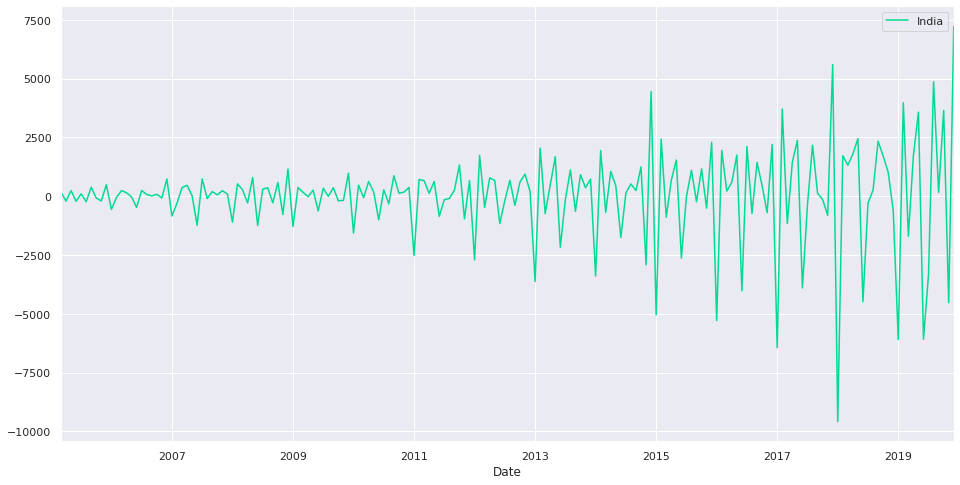

In [ ]:
lag_diff['India'].plot(figsize=(16, 8), legend=True)

Now all the data is stationary.

On stationarity:

Whilst stationarity is important for typical regressive algorithms such as the ARIMA or standard ML (i think). The deep learning im trying to implement here takes non-linearity and long term structures well. As such, lets try without inducing stationarity first

A very good primer on what stationarity is and how it can affect your models performance.

https://datascience.stackexchange.com/questions/24800/time-series-prediction-using-lstms-importance-of-making-time-series-stationary

## Train Test Split

In [ ]:
# next split the data set into the train and testing sets
# division of sequence is done so as to leave 1 year for the testset
trainset = lag_diff.iloc[:166,:]
testset = lag_diff.iloc[166:,:]

# might be worth looking into the different validation set splitting methods, in the deep learning file?

In [ ]:
# standardize the dataset
print(f"{trainset.shape[0]} train and {testset.shape[0]} test instances")

166 train and 12 test instances


In [ ]:
trainset.head()

,Indialag1,best resort in maldiveslag1,flights to maldiveslag1,honeymoon packages in maldiveslag1,maldives airportlag1,maldives beachlag1,maldives family triplag1,maldives honeymoonlag1,maldives hotelslag1,maldives resortlag1,...,maldives hotelslag12,maldives resortlag12,maldives visalag12,maldives water villalag12,maldives weatherlag12,male maldiveslag12,mumbai to maldiveslag12,sun island resort maldiveslag12,delhi to maldives flightlag12,India
Date,,,,,,,,,,,,,,,,,,,,,
2005-03-01,215.0,0.0,2.0,100.0,-57.0,26.0,0.0,85.0,48.0,35.0,...,43.0,-75.0,0.0,0.0,-190.0,100.0,100.0,0.0,0.0,184.0
2005-04-01,184.0,0.0,47.0,0.0,60.0,0.0,0.0,-24.0,24.0,44.0,...,-111.0,90.0,0.0,0.0,186.0,32.0,0.0,0.0,0.0,-207.0
2005-05-01,-207.0,0.0,-19.0,0.0,0.0,0.0,0.0,5.0,-48.0,-71.0,...,65.0,-76.0,0.0,0.0,-182.0,-37.0,0.0,0.0,0.0,242.0
2005-06-01,242.0,0.0,-7.0,0.0,0.0,0.0,0.0,-22.0,34.0,10.0,...,19.0,9.0,100.0,0.0,91.0,3.0,0.0,0.0,0.0,-215.0
2005-07-01,-215.0,0.0,-17.0,0.0,0.0,0.0,0.0,20.0,-11.0,71.0,...,-34.0,4.0,-200.0,0.0,0.0,-23.0,0.0,0.0,0.0,102.0


## Extracting Month and Season

In [ ]:
# we will extract the month and season for the training dataframe before splitting as train and test set

# first we extract the month, since monthly data might also help
trainset['month'] = trainset.index.month


# take the months that are high seasons into a list
high_season = [12, 1, 2, 3, 4, 5]

# then we extract the seasons from the monthly data
trainset['high_season'] = trainset['month'].apply(lambda x: 1 if x in high_season else 0)


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  # This is added back by InteractiveShellApp.init_path()


In [ ]:
# we do the same for the testset dataset
testset['month'] = testset.index.month

# take the index into a seperate variable for now
index_vals = testset.index

high_season = [12, 1, 2, 3, 4, 5]

testset['high_season'] = testset['month'].apply(lambda x: 1 if x in high_season else 0)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  if __name__ == '__main__':


### Encoding Data

Now that we have extracted month data we should encode them with dummy variables for our data prior to scaling

In [ ]:
trainset.shape

(166, 207)

In [ ]:
testset.shape

(12, 207)

In [ ]:
# import the onehotencoder class to implement encoding
from sklearn.preprocessing import OneHotEncoder


# set aside the categorical columns as a list object 
catcols = ['month']

# define the get dummies function to return encoded train and test sets
def get_dummies(trainset, testset, old_col_name):
    """Given a trainset, a testset, and the name of a column holding a 
    categorical variable, fit an encoder on the trainset, and use the 
    encoder to add dummy columns into the trainset and testset
    """
    
    one_hot_encoder = OneHotEncoder(drop="first", sparse=False)
    
    # the input to the encoder must be a 2-d numpy array,
    # so we take the column, extract their values and reshape the array to be 2-d
    # the old_col_name will be taken from the categorical columns list defined previously
    cat_vals = trainset[old_col_name].values.reshape(-1,1)

    # fit an encoder and transform the **trainset**
    # the output is a new numpy array
    transformed = one_hot_encoder.fit_transform(cat_vals)
    
    # in the list of new columns, convert numpy array to a list and
    # drop the first column, because we requested "drop='first'"
    new_col_names = one_hot_encoder.categories_[0].tolist()[1:]
    
    for i, new_col_name in enumerate(new_col_names):
        
        # put the transformed data as columns in the trainset dataframe
        trainset[new_col_name] = transformed[:,i]
    
    # transform the **testset** using the fitted encoder
    
    cat_vals = testset[old_col_name].values.reshape(-1,1)
    transformed = one_hot_encoder.transform(cat_vals)

    for i, new_col_name in enumerate(new_col_names):
        
        # put the transformed data as columns in the testset dataframe
        testset[new_col_name] = transformed[:,i]
    
    return trainset, testset


for col_name in catcols:
    trainset, testset = get_dummies(trainset, testset, col_name)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:33: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:43: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy


In [ ]:
# now that we have our dummy variables in place, we no longer need the old month column which we'll drop

del trainset['month']
del testset['month']

In [ ]:
trainset.head()

,Indialag1,best resort in maldiveslag1,flights to maldiveslag1,honeymoon packages in maldiveslag1,maldives airportlag1,maldives beachlag1,maldives family triplag1,maldives honeymoonlag1,maldives hotelslag1,maldives resortlag1,...,3,4,5,6,7,8,9,10,11,12
Date,,,,,,,,,,,,,,,,,,,,,
2005-03-01,215.0,0.0,2.0,100.0,-57.0,26.0,0.0,85.0,48.0,35.0,...,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2005-04-01,184.0,0.0,47.0,0.0,60.0,0.0,0.0,-24.0,24.0,44.0,...,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2005-05-01,-207.0,0.0,-19.0,0.0,0.0,0.0,0.0,5.0,-48.0,-71.0,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2005-06-01,242.0,0.0,-7.0,0.0,0.0,0.0,0.0,-22.0,34.0,10.0,...,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2005-07-01,-215.0,0.0,-17.0,0.0,0.0,0.0,0.0,20.0,-11.0,71.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


## Scaling data

Neural Networks work better with scaled data, so we'll be doing the appropriate scaling beforehand

In [ ]:
from sklearn.preprocessing import StandardScaler
scaler = StandardScaler()


# take the target (Italy) out before we scale
trainset_target = trainset["India"].values

# take predictors as seperate dataframe
trainset_predictors = trainset.drop(columns=["India"], axis=1)

# call the fit and transform method on our predictors
scaled_vals = scaler.fit_transform(trainset_predictors)

# put the scaled values back into the trainset dataframe
trainset = pd.DataFrame(scaled_vals, columns=trainset_predictors.columns)

# put the target back in
trainset['India'] = trainset_target


# inspect the data
trainset.head()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,
/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


,Indialag1,best resort in maldiveslag1,flights to maldiveslag1,honeymoon packages in maldiveslag1,maldives airportlag1,maldives beachlag1,maldives family triplag1,maldives honeymoonlag1,maldives hotelslag1,maldives resortlag1,...,4,5,6,7,8,9,10,11,12,India
0,0.110937,-0.001666,0.079256,2.875291,-1.730083,1.104223,0.001282,3.686624,2.103152,1.200522,...,-0.303488,-0.303488,-0.303488,-0.303488,-0.303488,-0.303488,-0.303488,-0.303488,-0.303488,184.0
1,0.092937,-0.001666,2.033199,-0.017952,1.818890,-0.007470,0.001282,-1.063823,1.045203,1.511368,...,3.295018,-0.303488,-0.303488,-0.303488,-0.303488,-0.303488,-0.303488,-0.303488,-0.303488,-207.0
2,-0.134093,-0.001666,-0.832584,-0.017952,-0.001096,-0.007470,0.001282,0.200057,-2.128645,-2.460551,...,-0.303488,3.295018,-0.303488,-0.303488,-0.303488,-0.303488,-0.303488,-0.303488,-0.303488,242.0
3,0.126614,-0.001666,-0.311532,-0.017952,-0.001096,-0.007470,0.001282,-0.976659,1.486015,0.337062,...,-0.303488,-0.303488,3.295018,-0.303488,-0.303488,-0.303488,-0.303488,-0.303488,-0.303488,-215.0
4,-0.138738,-0.001666,-0.745742,-0.017952,-0.001096,-0.007470,0.001282,0.853789,-0.497640,2.443906,...,-0.303488,-0.303488,-0.303488,3.295018,-0.303488,-0.303488,-0.303488,-0.303488,-0.303488,102.0


In [ ]:
# take the target (Italy) out before we scale
testset_target = testset["India"].values

# take predictors as seperate dataframe
testset_predictors = testset.drop(columns=["India"], axis=1)

# call the fit and transform method on our predictors
scaled_vals = scaler.transform(testset_predictors)

# put the scaled values back into the trainset dataframe
testset = pd.DataFrame(scaled_vals, columns=testset_predictors.columns)

# put the target back in
testset['India'] = testset_target


# inspect the data
testset.head()

/usr/local/lib/python3.7/dist-packages/sklearn/utils/validation.py:1692: FutureWarning: Feature names only support names that are all strings. Got feature names with dtypes: ['int', 'str']. An error will be raised in 1.2.
  FutureWarning,


,Indialag1,best resort in maldiveslag1,flights to maldiveslag1,honeymoon packages in maldiveslag1,maldives airportlag1,maldives beachlag1,maldives family triplag1,maldives honeymoonlag1,maldives hotelslag1,maldives resortlag1,...,4,5,6,7,8,9,10,11,12,India
0,-0.370993,-0.448316,-0.094428,-0.075817,-0.031429,-0.264014,0.214038,-0.322927,0.031335,-0.284630,...,-0.303488,-0.303488,-0.303488,-0.303488,-0.303488,-0.303488,-0.303488,-0.303488,-0.303488,-6097.0
1,-3.554057,0.530061,-0.094428,-0.191547,-0.122429,0.206317,0.001282,0.025729,0.031335,0.095293,...,-0.303488,-0.303488,-0.303488,-0.303488,-0.303488,-0.303488,-0.303488,-0.303488,-0.303488,3978.0
2,2.295882,-0.639737,0.209519,0.039913,0.120236,-0.092984,0.143119,0.025729,-0.189071,-0.042861,...,-0.303488,-0.303488,-0.303488,-0.303488,-0.303488,-0.303488,-0.303488,-0.303488,-0.303488,-1699.0
3,-1.000406,0.168487,-0.137848,0.329237,-0.061763,-0.050227,0.072200,0.243640,0.119497,0.095293,...,3.295018,-0.303488,-0.303488,-0.303488,-0.303488,-0.303488,-0.303488,-0.303488,-0.303488,1735.0
4,0.993508,0.423715,0.166098,-0.162614,0.302235,0.249075,-0.211475,0.156475,0.251741,0.267985,...,-0.303488,3.295018,-0.303488,-0.303488,-0.303488,-0.303488,-0.303488,-0.303488,-0.303488,3579.0


### Split into X and Y sets

In [ ]:
# split the target and the non-targets into X and Y sets

# take italy as the target values to the y
ytrain = trainset['India'].copy()
ytest = testset['India'].copy()

# take the predictors to the X
Xtrain = trainset.drop('India', axis=1)
Xtest = testset.drop('India', axis=1)



## Feature Selection

We have a lot of features in the data which may be a hindrance to the performance of the dataset. As such we will be using feature selection using the Maximal Information Criterion (MIC) as a way to filter the features in the dataset.

https://medium.com/@rhondenewint93/on-maximal-information-coefficient-a-modern-approach-for-finding-associations-in-large-data-sets-ba8c36ebb96b

https://en.wikipedia.org/wiki/Maximal_information_coefficient

In [ ]:
!pip install minepy

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 496 kB 7.2 MB/s 
  Created wheel for minepy: filename=minepy-1.2.6-cp37-cp37m-linux_x86_64.whl size=177581 sha256=4caefde0239fba1a6ce6ca51144b7c96b8adb820ba12afe80ffe90ddfae68083
  Stored in directory: /root/.cache/pip/wheels/81/71/75/403a33428e468a25c93fa7b672d070b304f36642eb699a29e0
Successfully built minepy


In [ ]:
# import the MINE module and instantiate the class
from minepy import MINE
miner = MINE(alpha=0.6, c=15, est="mic_approx")

# save the columns of the Xtrain in col_list
col_list = Xtrain.columns.values.tolist()

# function to return a dataframe with all the MIC scores
def build_minedf(array):
  
  minedf = pd.DataFrame() # create an empty dataframe to hold all of our associations
  

  for column in col_list:
      col = array[column].values # convert the columns values to a 1d array as required by compute score
      miner.compute_score(col, ytrain) # compute scores for the selected column and ytrain
      micvalue = miner.mic() # get only the mic score and save to micvalue
      micvaluenp = np.array([micvalue]) # put the mic value calculated above into a numpy array  
      minedf[column] = micvaluenp # join to dataframe
    
  return minedf

# implement the above function on our Xtrain dataset
mic_scores = build_minedf(Xtrain)

# transpose the dataframe
micscore = mic_scores.T
micscores = micscore.rename(columns={micscore.columns[0]: "MIC" })


/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:19: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead.  To get a de-fragmented frame, use `newframe = frame.copy()`


Now that we have the MIC scores in a dataframe, lets visualize them

In [ ]:
micscores.head()

,MIC
Indialag1,0.335200
best resort in maldiveslag1,0.243025
flights to maldiveslag1,0.178288
honeymoon packages in maldiveslag1,0.213106
maldives airportlag1,0.224504


Lets visualize the top 15 MIC scores in our dataset

In [ ]:
micscores

,MIC
Indialag1,0.335200
best resort in maldiveslag1,0.243025
flights to maldiveslag1,0.178288
honeymoon packages in maldiveslag1,0.213106
maldives airportlag1,0.224504
...,...
8,0.182638
9,0.178211
10,0.206867
11,0.183686


Text(0.5, 1.0, 'Top 15 MIC Association - India')

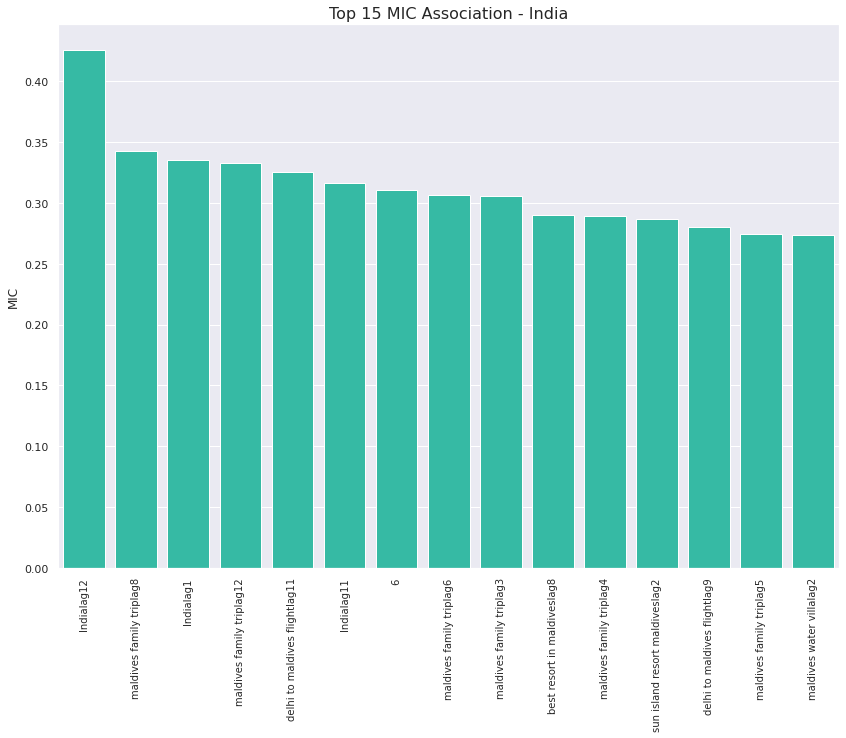

In [ ]:
# increase the size of the following seaborn countplot
sns.set(rc={'figure.figsize':(14,10)})


plot_order = micscores.sort_values(by='MIC', ascending=False).head(15) # change the 'head' argument to change how many we want

# use the seaborn countplot function and only return top 5 results
ax = sns.barplot(data=plot_order, x=plot_order.index.tolist(), y='MIC', 
                  color='#20d0b2')

ax.set_xticklabels(ax.get_xticklabels(),rotation = 90, size = 10)

# set the title of the plot
ax.set_title('Top 15 MIC Association - India', fontsize=16)



Text(0.5, 1.0, 'Lowest 15 MIC scores in trainset')

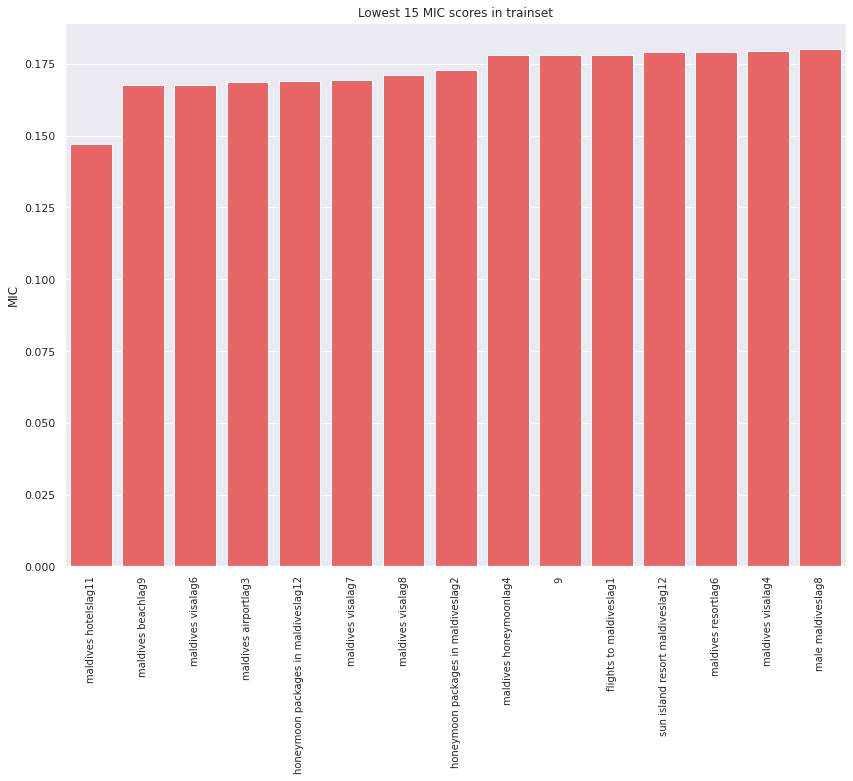

In [ ]:
# increase the size of the following seaborn countplot
sns.set(rc={'figure.figsize':(14,10)})


plot_order = micscores.sort_values(by='MIC', ascending=True).head(15) # change the 'head' argument to change how many we want

# use the seaborn countplot function and only return top 5 results
ax = sns.barplot(data=plot_order, x=plot_order.index.tolist(), y='MIC', 
                  color='#ff5050')

ax.set_xticklabels(ax.get_xticklabels(),rotation = 90, size = 10)

# set the title of the plot
ax.set_title('Lowest 15 MIC scores in trainset')


Now lets make some code to eliminate lags with less than 0.20 MIC score

In [ ]:
# first save dataframe with less than 0.20 MIC
to_remove = micscores[micscores.MIC < 0.20]
print(f'We have {to_remove.shape[0]} features lower than 0.20\n')

We have 69 features lower than 0.20



In [ ]:
# remove the features from the original Xtrain and Xtest dataset
col_list = to_remove.index.tolist()

def remove_cols(df):
  for column in df:
    if column in col_list:
      del df[column]
  return df

# implement the columns 
Xtrain = remove_cols(Xtrain)
Xtest = remove_cols(Xtest)

In [ ]:
# verify if the columns really have been removed properly
print(f' The dataset now has {Xtrain.shape[1]} fetures\n')

 The dataset now has 147 fetures



## Calculate MIC on Original Search Data

In [ ]:
# we have the main_df so we just need to use that
# save the columns of the Xtrain in col_list
col_list = main_df.columns.values.tolist()

# function to return a dataframe with all the MIC scores
def build_minedf(array):
  
  minedf = pd.DataFrame() # create an empty dataframe to hold all of our associations
  

  for column in col_list:
      col = array[column].values # convert the columns values to a 1d array as required by compute score
      miner.compute_score(col, main_df['India']) # compute scores for the selected column and ytrain
      micvalue = miner.mic() # get only the mic score and save to micvalue
      micvaluenp = np.array([micvalue]) # put the mic value calculated above into a numpy array  
      minedf[column] = micvaluenp # join to dataframe
    
  return minedf

# implement the above function on our Xtrain dataset
mic_scores = build_minedf(main_df)

# transpose the dataframe
micscore = mic_scores.T
micscores = micscore.rename(columns={micscore.columns[0]: "MIC" })

In [ ]:
micscores

,MIC
India,1.000000
best resort in maldives,0.699202
flights to maldives,0.372364
honeymoon packages in maldives,0.498942
maldives airport,0.434473
maldives beach,0.370754
maldives family trip,0.534593
maldives honeymoon,0.342803
maldives hotels,0.593737
maldives resort,0.408173


We've gone from 233 to 177 features. Let's see if this improves anything

## Model Building

Since we are working with time-series and sequential data, we cannot use random folds. Instead we use timeseries split

Full training set size: 166

Split 1
Observations: 58
Training Observations: 31
Validation Observations: 27
Split 2
Observations: 85
Training Observations: 58
Validation Observations: 27
Split 3
Observations: 112
Training Observations: 85
Validation Observations: 27
Split 4
Observations: 139
Training Observations: 112
Validation Observations: 27
Split 5
Observations: 166
Training Observations: 139
Validation Observations: 27


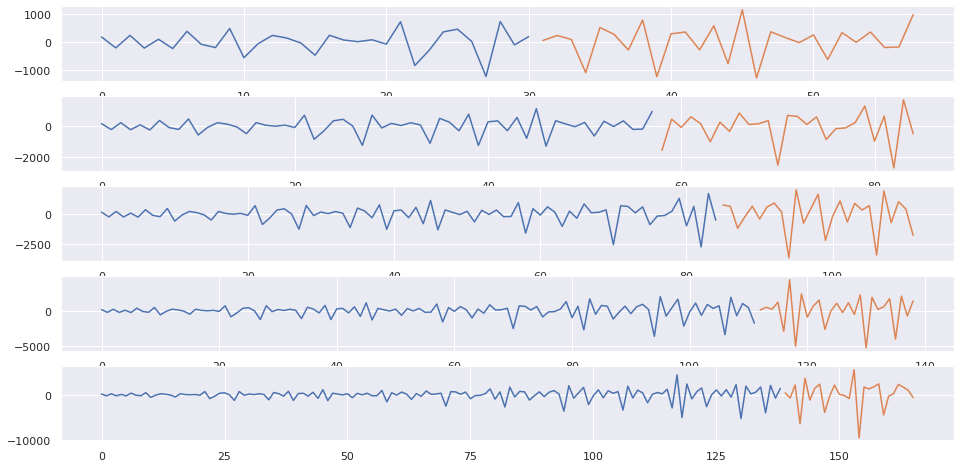

In [ ]:
from sklearn.model_selection import TimeSeriesSplit, GridSearchCV

tscv = TimeSeriesSplit(n_splits=5)
plt.figure(figsize=(16, 8))
plt.figure(1)
print(f"Full training set size: {Xtrain.shape[0]}\n")
index = 1

# How the loop works below
for train_index, test_index in tscv.split(Xtrain):

    # set train and test indexes to train and test indexes set in the tscv.split (Time-Series split class)
    train = ytrain[train_index]
    test = ytrain[test_index]
    obs = len(train) + len(test)
    print(f'Split {index}')
    print(f'Observations: {obs}')
    print(f'Training Observations: {len(train)}')
    print(f'Validation Observations: {len(test)}')
    plt.subplot(510 + index)
    plt.plot(train)
    plt.plot([None for i in train] + 
                 [x for x in test] + 
                 [None for i in range(obs, Xtrain.shape[0])])
    index += 1

## Error Metrics Definition

In [ ]:
# import the error metrics from sklearn
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_percentage_error
from sklearn.metrics import r2_score

# define the theils u metric function
# we'll be using the theils U2 statistic for this
def theils_u2(y, f):
    df = pd.DataFrame({'f_i+1':f, 'y_i+1': y})
    df['y_i'] = df['y_i+1'].shift(periods=1)
    df['numerator'] = np.square((df['f_i+1'] - df['y_i+1']) / df['y_i'])
    df['denominator'] = np.square((df['y_i+1'] - df['y_i']) / df['y_i'])
    df.dropna(inplace=True)
    return np.sqrt(np.sum(df['numerator'])/np.sum(df['denominator']))

# define the function to get accuracy scores, takes as 
def get_metrics(ytrue, yhat, model):
    
    # calculate the metrics
    mae = mean_absolute_error(ytrue, yhat)
    rmse = mean_squared_error(ytrue, yhat, squared=False) # we set squared as false to give us rmse
    mape = mean_absolute_percentage_error(ytrue, yhat)
    r2 = r2_score(ytrue, yhat)
    mda = get_mda(ytrue, yhat)
    theil_u2 = theils_u2(ytrue, yhat)
    
    # put the metrics into a dataframe
    metrics = pd.DataFrame({
                'Mean Absolute Error': mae,
                'Root Mean Squared Error': rmse,
                'Mean Absolute Percentage Error': mape,
                'R2 Score': r2,
                'MDA Score': mda,
                'Theils U2': theil_u2
    }, index=[model]).sort_index()

    return metrics # this function returns a dataframe with the error values we calculated


# the below is a convenient function to only plot the error metrics as a bar chart
def plot_metrics(dataframe, model):
    ax = sns.barplot(data=dataframe, palette='pastel')
    ax.set_title('Error Metrics for'+" "+ model +" "+'model')

In [ ]:
def print_cv_results(grid_search, col_width=100):
    """Given a grid search object, print a table with the 
    cross-validation results
    """
    results = pd.DataFrame(grid_search.cv_results_
                             )[['params', 'mean_train_score', 'mean_test_score']]
    results["diff, %"] = 100*(results["mean_train_score"]-results["mean_test_score"]
                                                         )/results["mean_train_score"]

    pd.set_option('display.max_colwidth', col_width)
    display(results.sort_values('mean_test_score', ascending=False))

In [ ]:
import warnings
warnings.filterwarnings("ignore")

## Random Forest Model

First we'll see how our Random Forest model fairs

In [ ]:
import time
from sklearn.ensemble import RandomForestRegressor

forest_reg = RandomForestRegressor(random_state=7)
param_grid = [
    {'n_estimators': [2, 3, 5, 10, 20, 50, 100], 
     'max_depth': [2, 4, 6, 8, 10, None]},
]

tscv = TimeSeriesSplit(n_splits=5)
grid_search = GridSearchCV(estimator=forest_reg, cv=tscv,
                        param_grid=param_grid,
                        scoring='neg_root_mean_squared_error', 
                        return_train_score=True)

start = time.time()
rf_grid = grid_search.fit(Xtrain, ytrain)
duration = time.time() - start
print(f'Took {duration:.3f} seconds')

Took 41.800 seconds


In [ ]:
# print the results of our grid search with the random forest
print_cv_results(rf_grid)

,params,mean_train_score,mean_test_score,"diff, %"
41,"{'max_depth': None, 'n_estimators': 100}",-188.728939,-1181.998056,-526.294017
20,"{'max_depth': 6, 'n_estimators': 100}",-211.926279,-1183.762117,-458.572595
27,"{'max_depth': 8, 'n_estimators': 100}",-194.064593,-1183.993031,-510.102551
34,"{'max_depth': 10, 'n_estimators': 100}",-189.255236,-1186.443130,-526.901085
19,"{'max_depth': 6, 'n_estimators': 50}",-221.162357,-1190.518232,-438.300573
13,"{'max_depth': 4, 'n_estimators': 100}",-261.960294,-1190.890683,-354.607323
40,"{'max_depth': None, 'n_estimators': 50}",-197.866789,-1191.059827,-501.950348
33,"{'max_depth': 10, 'n_estimators': 50}",-197.624667,-1193.196418,-503.768972
39,"{'max_depth': None, 'n_estimators': 20}",-216.608048,-1193.531905,-451.009953
18,"{'max_depth': 6, 'n_estimators': 20}",-237.204318,-1194.031544,-403.376816


In [ ]:
# save the best random forest model
best_rf = rf_grid.best_estimator_

# save the predictions for the yhat in our best predictor
yhat_rf = best_rf.predict(Xtest)

# build the metric plot
rferror = get_metrics(ytest, yhat_rf, 'Random Forest')

In [ ]:
rferror

,Mean Absolute Error,Root Mean Squared Error,Mean Absolute Percentage Error,R2 Score,MDA Score,Theils U2
Random Forest,2667.509167,3073.709855,1.151987,0.504011,1.0,0.676907


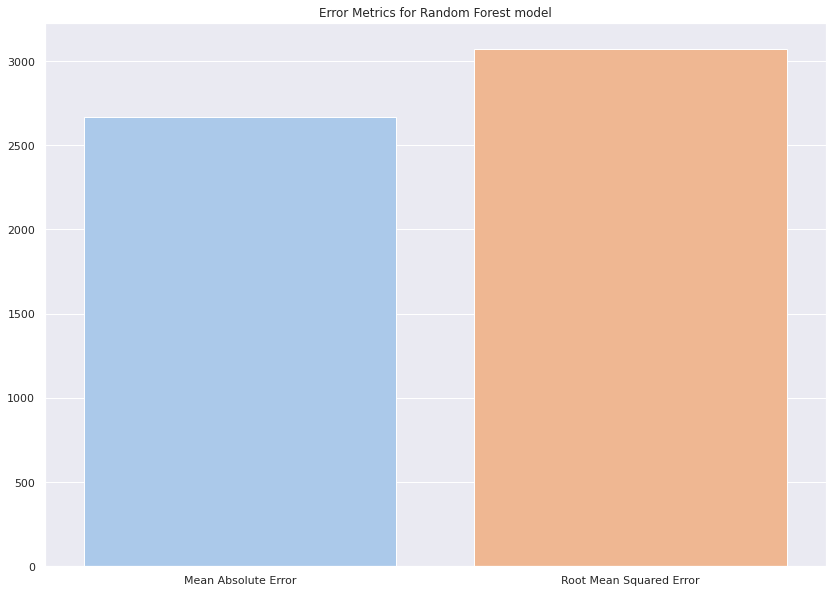

In [ ]:
plot_metrics(rferror[['Mean Absolute Error', 'Root Mean Squared Error']], 'Random Forest')

We can also find out the best features in our random forest model using feature importances

In [ ]:
# get the feature importances
rf_importance = best_rf.feature_importances_
feat_label = Xtest.columns
indices = np.argsort(rf_importance)[::-1]

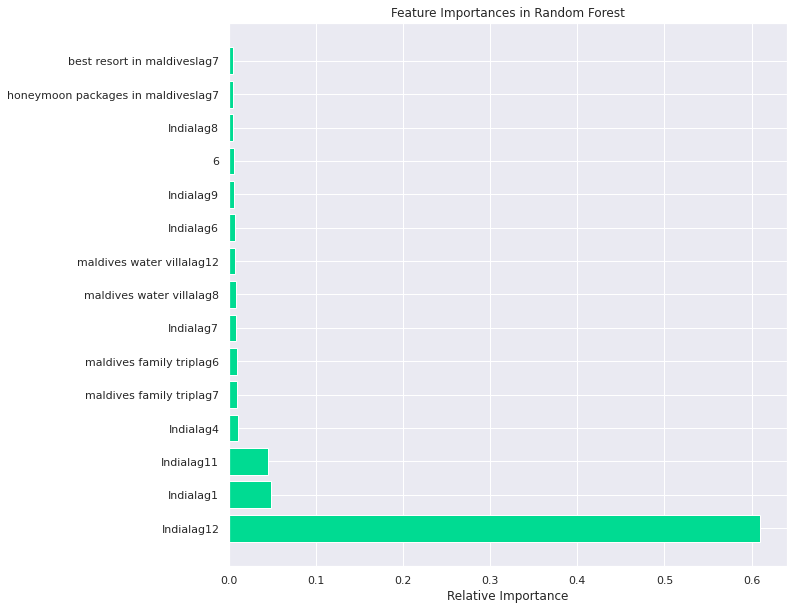

In [ ]:
# set number of features to show 
num_features = 15

# set the theme for sns
sns.set_theme(style='darkgrid', palette='winter_r')

# plot the relative importances
plt.figure(figsize=(10,10))
plt.title('Feature Importances in Random Forest')

# only visualize the top 15 features
plt.barh(range(num_features), rf_importance[indices[:num_features]], align='center')
plt.yticks(range(num_features), [feat_label[i] for i in indices[:num_features]])
plt.xlabel('Relative Importance')
plt.show()

Based on the above, we understand that the most important predictor or tourism volume in Italy for time t is most likely the same arrival for Italy one year ago. In other words, we can expect a similar number of tourist arrivals in the current month as we see in the same month during the previous year

In [ ]:
rfimportance = pd.DataFrame({'Importance scores': rf_importance},
                             index=feat_label)

In [ ]:
rfimportance

,Importance scores
Indialag1,0.048634
best resort in maldiveslag1,0.001628
honeymoon packages in maldiveslag1,0.003652
maldives airportlag1,0.001459
maldives beachlag1,0.001358
...,...
2,0.000588
6,0.005578
7,0.000047
10,0.000029


## Support Vector Regression

In [ ]:
from sklearn.svm import SVR

# radial basis function, might help to do some research on this
svr = SVR()
param_grid = [
        {
            "C": [0.001, 0.005, 0.01, 0.05, 0.1, 1.0, 5.0],
            "epsilon": [0.001, 0.01],
            "gamma": [0.0001, 0.001, 0.01, 0.1, "scale", "auto"],
            "kernel": ['rbf', 'linear', 'polynomial']
        }
]

tscv = TimeSeriesSplit(n_splits=5)
grid_search = GridSearchCV(estimator=svr, cv=tscv,
                        param_grid=param_grid,
                        scoring='neg_root_mean_squared_error', 
                        return_train_score=True)

start = time.time()
svr_grid = grid_search.fit(Xtrain, ytrain)
duration = time.time() - start
print(f'Took {duration:.3f} seconds')

Took 10.278 seconds


In [ ]:
# print the results
print_cv_results(svr_grid)

,params,mean_train_score,mean_test_score,"diff, %"
217,"{'C': 5.0, 'epsilon': 0.001, 'gamma': 0.0001, 'kernel': 'linear'}",-422.492317,-1511.088702,-257.660635
232,"{'C': 5.0, 'epsilon': 0.001, 'gamma': 'auto', 'kernel': 'linear'}",-422.492317,-1511.088702,-257.660635
229,"{'C': 5.0, 'epsilon': 0.001, 'gamma': 'scale', 'kernel': 'linear'}",-422.492317,-1511.088702,-257.660635
226,"{'C': 5.0, 'epsilon': 0.001, 'gamma': 0.1, 'kernel': 'linear'}",-422.492317,-1511.088702,-257.660635
223,"{'C': 5.0, 'epsilon': 0.001, 'gamma': 0.01, 'kernel': 'linear'}",-422.492317,-1511.088702,-257.660635
...,...,...,...,...
239,"{'C': 5.0, 'epsilon': 0.01, 'gamma': 0.001, 'kernel': 'polynomial'}",NaN,NaN,NaN
242,"{'C': 5.0, 'epsilon': 0.01, 'gamma': 0.01, 'kernel': 'polynomial'}",NaN,NaN,NaN
245,"{'C': 5.0, 'epsilon': 0.01, 'gamma': 0.1, 'kernel': 'polynomial'}",NaN,NaN,NaN
248,"{'C': 5.0, 'epsilon': 0.01, 'gamma': 'scale', 'kernel': 'polynomial'}",NaN,NaN,NaN


In [ ]:
# save the best svr model
best_svr = svr_grid.best_estimator_

# get the predictions of the best model
yhat_svr = best_svr.predict(Xtest)

# save the metrics 
svr_metrics = get_metrics(ytest, yhat_svr, 'Support Vector Regression')

In [ ]:
svr_metrics

,Mean Absolute Error,Root Mean Squared Error,Mean Absolute Percentage Error,R2 Score,MDA Score,Theils U2
Support Vector Regression,3207.935399,3611.332711,0.905077,0.31533,0.909091,0.749183


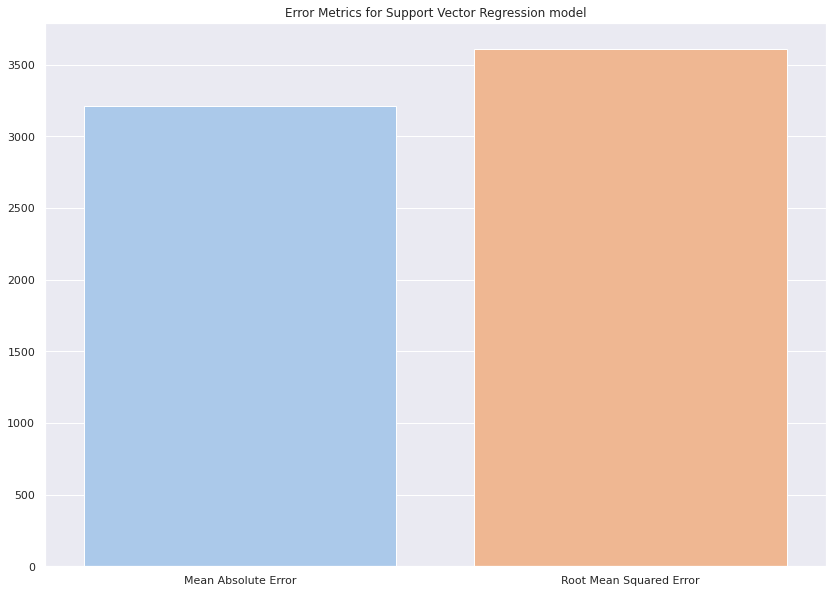

In [ ]:
# plot the metrics for SVR
plot_metrics(svr_metrics[['Mean Absolute Error', 'Root Mean Squared Error']], 'Support Vector Regression')

## XGBoost

We'll also try the XGBoost model on our data and see what happens

In [ ]:
# xgboost is not part of the standard sklearn library, but the colab environment should have it installed as well
import xgboost as xgb

xgbreg = xgb.XGBRegressor(random_state=7)

In [ ]:
# set the different sampling and hyperparameter combinations
param_grid = [
    {   
    'n_estimators': [400, 700, 1000],
    'colsample_bytree': [0.7],
    'max_depth': [15,20,25],
    'reg_alpha': [1.1, 1.2, 1.3],
    'reg_lambda': [1.1, 1.2, 1.3],
    'subsample': [0.7, 0.8, 0.9]
    },
]

# theres too many warnings here
import warnings
warnings.filterwarnings("ignore")

# define the grid search parameters
# we use macro scores as it does not become biased due to class imbalances.
xg_grid_search = GridSearchCV(estimator=xgbreg, param_grid=param_grid, cv=tscv, 
                              scoring='neg_root_mean_squared_error',
                              return_train_score=True)


xg_grid_search.fit(Xtrain, ytrain)

[09:57:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:57:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:57:29] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:57:30] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:57:31] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:57:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:57:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
[09:57:32] WARNING: /workspace/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of re

GridSearchCV(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=5, test_size=None),
             estimator=XGBRegressor(random_state=7),
             param_grid=[{'colsample_bytree': [0.7], 'max_depth': [15, 20, 25],
                          'n_estimators': [400, 700, 1000],
                          'reg_alpha': [1.1, 1.2, 1.3],
                          'reg_lambda': [1.1, 1.2, 1.3],
                          'subsample': [0.7, 0.8, 0.9]}],
             return_train_score=True, scoring='neg_root_mean_squared_error')

In [ ]:
print_cv_results(xg_grid_search)

,params,mean_train_score,mean_test_score,"diff, %"
196,"{'colsample_bytree': 0.7, 'max_depth': 25, 'n_estimators': 700, 'reg_alpha': 1.1, 'reg_lambda': ...",-0.171967,-1080.088270,-627977.125096
223,"{'colsample_bytree': 0.7, 'max_depth': 25, 'n_estimators': 1000, 'reg_alpha': 1.1, 'reg_lambda':...",-0.171820,-1080.088299,-628516.765996
169,"{'colsample_bytree': 0.7, 'max_depth': 25, 'n_estimators': 400, 'reg_alpha': 1.1, 'reg_lambda': ...",-0.172876,-1080.088341,-624675.409626
7,"{'colsample_bytree': 0.7, 'max_depth': 15, 'n_estimators': 400, 'reg_alpha': 1.1, 'reg_lambda': ...",-0.172195,-1080.105280,-627157.488563
34,"{'colsample_bytree': 0.7, 'max_depth': 15, 'n_estimators': 700, 'reg_alpha': 1.1, 'reg_lambda': ...",-0.171274,-1080.105344,-630531.451195
...,...,...,...,...
162,"{'colsample_bytree': 0.7, 'max_depth': 25, 'n_estimators': 400, 'reg_alpha': 1.1, 'reg_lambda': ...",-0.158565,-1128.222932,-711419.118855
81,"{'colsample_bytree': 0.7, 'max_depth': 20, 'n_estimators': 400, 'reg_alpha': 1.1, 'reg_lambda': ...",-0.158565,-1128.222932,-711419.118855
54,"{'colsample_bytree': 0.7, 'max_depth': 15, 'n_estimators': 1000, 'reg_alpha': 1.1, 'reg_lambda':...",-0.151828,-1128.404259,-743112.817699
27,"{'colsample_bytree': 0.7, 'max_depth': 15, 'n_estimators': 700, 'reg_alpha': 1.1, 'reg_lambda': ...",-0.152220,-1128.404339,-741199.612605


In [ ]:
# save the best svr model
best_xgb = xg_grid_search.best_estimator_

# get the predictions of the best model
yhat_xgb = best_xgb.predict(Xtest)

# save the metrics 
xgb_metrics = get_metrics(ytest, yhat_xgb, 'XG Boost')

In [ ]:
xgb_metrics

,Mean Absolute Error,Root Mean Squared Error,Mean Absolute Percentage Error,R2 Score,MDA Score,Theils U2
XG Boost,2238.298513,2576.296952,1.054118,0.651552,1.0,0.605417


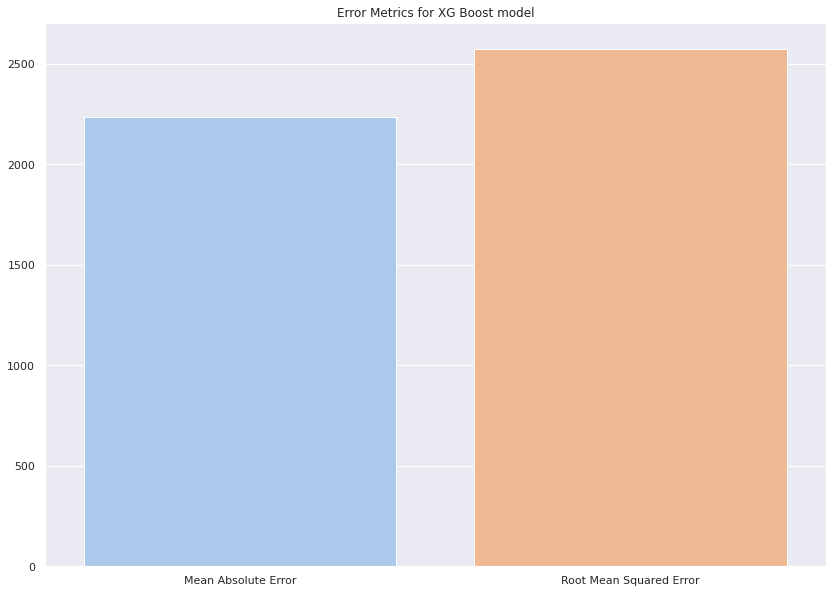

In [ ]:
# plot the metrics for SVR
plot_metrics(xgb_metrics[['Mean Absolute Error', 'Root Mean Squared Error']], 'XG Boost')

We can also calculate the feature importances for the XG Boost model

In [ ]:
# get the feature importances
xgb_importance = best_xgb.feature_importances_
feat_label = Xtest.columns
indices = np.argsort(xgb_importance)[::-1]

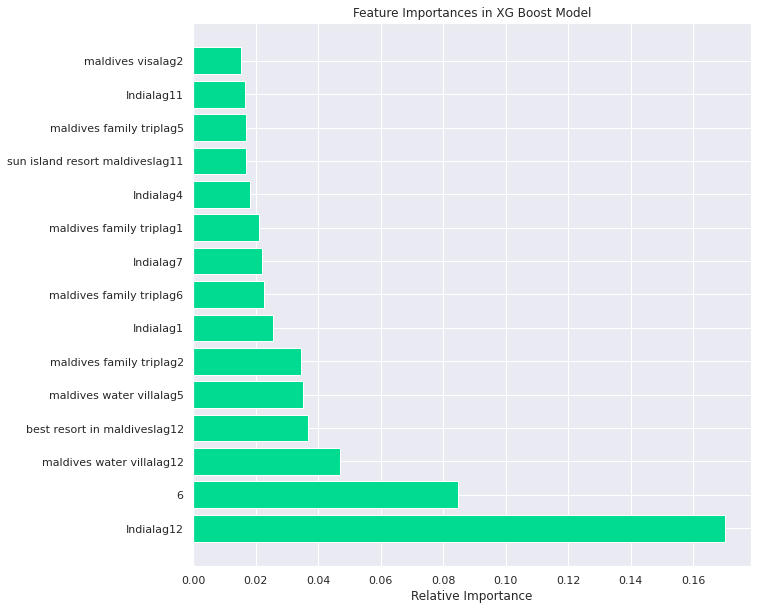

In [ ]:
# set number of features to show 
num_features = 15

# set the theme for sns
sns.set_theme(style='darkgrid', palette='winter_r')

# plot the relative importances
plt.figure(figsize=(10,10))
plt.title('Feature Importances in XG Boost Model')

# only visualize the top 15 features
plt.barh(range(num_features), xgb_importance[indices[:num_features]], align='center')
plt.yticks(range(num_features), [feat_label[i] for i in indices[:num_features]])
plt.xlabel('Relative Importance')
plt.show()

In [ ]:
xgb_importance

array([2.54189894e-02, 3.88589990e-03, 9.46539454e-04, 9.04405082e-04,
       1.99916703e-03, 2.10824013e-02, 6.15114986e-04, 1.96757889e-03,
       7.19503826e-03, 2.40624673e-03, 2.68678716e-03, 2.32034712e-03,
       9.57455765e-03, 1.35388400e-03, 1.10040454e-03, 1.39840506e-03,
       5.63372998e-03, 2.51706038e-03, 3.46774757e-02, 4.36077313e-03,
       1.53065175e-02, 6.55774912e-03, 6.76310016e-03, 1.18276179e-02,
       1.26589253e-03, 8.04244261e-03, 1.68598618e-03, 5.73838176e-03,
       2.97034334e-04, 2.55802134e-03, 1.13139150e-03, 1.19068194e-03,
       5.98266488e-04, 1.52651372e-03, 1.59817783e-03, 5.24390431e-04,
       9.76887811e-03, 4.59869407e-05, 1.80557929e-02, 3.76920123e-03,
       4.60052583e-03, 1.81672594e-03, 6.50978531e-04, 1.93035451e-03,
       2.72584800e-03, 6.11690775e-05, 8.21887702e-03, 8.27779621e-03,
       3.38911428e-03, 9.90042929e-03, 1.69481449e-02, 5.50823286e-03,
       1.07404089e-03, 1.28921506e-03, 3.52950841e-02, 2.96048122e-04,
      

In [ ]:
xgbimportance = pd.DataFrame({'Importance scores': xgb_importance},
                             index=feat_label)

In [ ]:
xgbimportance

,Importance scores
Indialag1,2.541899e-02
best resort in maldiveslag1,3.885900e-03
honeymoon packages in maldiveslag1,9.465395e-04
maldives airportlag1,9.044051e-04
maldives beachlag1,1.999167e-03
...,...
2,0.000000e+00
6,8.468336e-02
7,2.319451e-13
10,0.000000e+00


## Compare Random Forest and SVR

In [ ]:
svrpredictions = pd.DataFrame({'Actual': ytest, "Support Vector Regression": yhat_svr})
rfpredictions = pd.DataFrame({'Actual': ytest, "Random Forest": yhat_rf})
xgpredictions = pd.DataFrame({'Actual': ytest, "XG Boost": yhat_xgb})

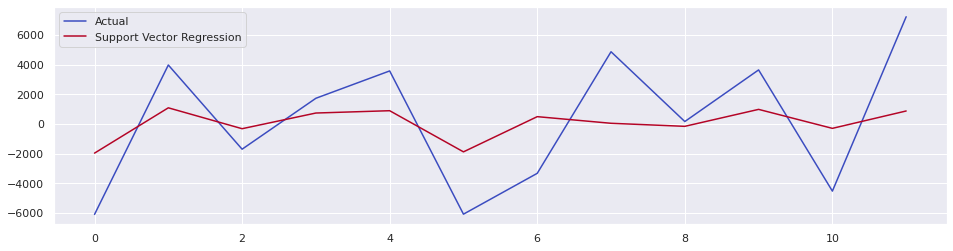

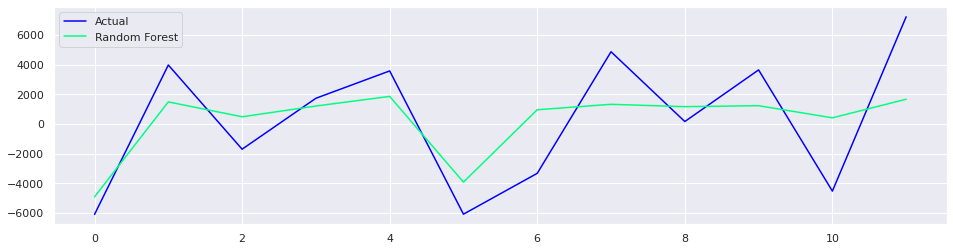

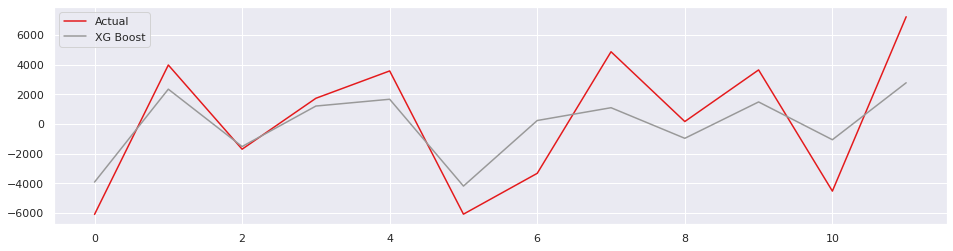

In [ ]:
# plot both the RF and SVR side by side
svrpredictions.plot(figsize=(16,4), colormap='coolwarm')
rfpredictions.plot(figsize=(16,4), colormap='winter')
xgpredictions.plot(figsize=(16,4), colormap='Set1')

In [ ]:
# append all the error metrics into one table
mlerrors = svr_metrics.append([rferror, xgb_metrics])

mlerrors

,Mean Absolute Error,Root Mean Squared Error,Mean Absolute Percentage Error,R2 Score,MDA Score,Theils U2
Support Vector Regression,3207.935399,3611.332711,0.905077,0.315330,0.909091,0.749183
Random Forest,2667.509167,3073.709855,1.151987,0.504011,1.000000,0.676907
XG Boost,2238.298513,2576.296952,1.054118,0.651552,1.000000,0.605417


We see that the data mainly follows the predictions closely. The fall in the 20th month seems to be an issue, both algorithms seem to fall short of extreme falls and such.

# Deep Learning Models

In [ ]:
from keras import callbacks
# first lets create our initial deep learning model
import tensorflow as tf
from keras.models import Sequential
from keras.layers import Dense

# this will help us visualize the neural network shape, can help when experimenting
from keras.utils.vis_utils import plot_model
from keras.callbacks import EarlyStopping

input_dim = Xtrain.shape[1]

# we define a function to create a model, this takes care of both build and compile steps
def model_dnn(units, activation):
  # the model is a sequential model
    model=Sequential()
    # we add the first hidden layer, note we do not explicitly mention number of input units (rather we specify it by the input_dim function)
    model.add(Dense(units=units, input_dim=input_dim, activation=activation))
    # we add another hidden layer
    model.add(Dense(64, activation=activation))
    # we add the last layer - i.e the output should be of shape 1 since we want one prediction
    model.add(Dense(1))
    # after building the model it needs to be compiled
    model.compile(loss='mean_squared_error',  optimizer='adam',metrics = ['mse', 'mae']
                  )
    return model

# we build 3 models with an input shape of 233, which is also number of columns in Xtrain (refer input dim = lookback)
model1 = model_dnn(177, 'relu')
model2 = model_dnn(64, 'relu')
model3 = model_dnn(12, 'relu')


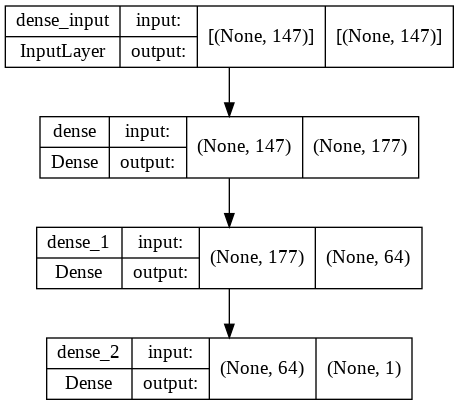

In [ ]:
plot_model(model1, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

We have built and compiled a few deep network models. However our Xtrain dataset is in dataframe format, so we'll have to convert it to a numpy array or tensor before we fit the models

In [ ]:
# the tensorflow convert to tensor argument can convert numerical features to a tensor
trainX = tf.convert_to_tensor(Xtrain)
testX = tf.convert_to_tensor(Xtest)

In [ ]:
trainX

<tf.Tensor: shape=(166, 147), dtype=float64, numpy=
array([[ 1.10937041e-01, -1.66564907e-03,  2.87529103e+00, ...,
        -3.03488489e-01, -3.03488489e-01, -3.03488489e-01],
       [ 9.29372301e-02, -1.66564907e-03, -1.79520504e-02, ...,
        -3.03488489e-01, -3.03488489e-01, -3.03488489e-01],
       [-1.34092648e-01, -1.66564907e-03, -1.79520504e-02, ...,
        -3.03488489e-01, -3.03488489e-01, -3.03488489e-01],
       ...,
       [ 1.34479507e+00,  5.72598899e-01, -1.33681774e-01, ...,
        -3.03488489e-01,  3.29501788e+00, -3.03488489e-01],
       [ 9.82476291e-01, -6.61006426e-01, -7.58169120e-02, ...,
        -3.03488489e-01, -3.03488489e-01, -3.03488489e-01],
       [ 5.80674052e-01,  5.51329841e-01,  1.26710103e-01, ...,
        -3.03488489e-01, -3.03488489e-01,  3.29501788e+00]])>

In [ ]:
# fit the model and save it to dnn results object (important as we need it to be subscriptable)
dnn1 = model1.fit(trainX, ytrain, epochs=400, batch_size=12, validation_data=(testX, ytest),
                  callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=0)

In [ ]:
# build the second model
dnn2 = model2.fit(trainX, ytrain, epochs=100, batch_size=50, validation_data=(testX, ytest),
                  callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=0)

In [ ]:
# build the 3rd model
dnn3 = model3.fit(trainX, ytrain, epochs=100, batch_size=50, validation_data=(testX, ytest),
                  callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=0)

## Evaluate Deep Learning Models

### Model Loss

In [ ]:
# check performance of dnn model on testing dataset
def model_loss(history, model):
    plt.figure(figsize=(8,4))
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Test Loss')
    plt.title('Model Loss Curve' + '-' + model)
    plt.ylabel('Loss')
    plt.xlabel('Epochs')
    plt.legend(loc='upper right')
    plt.show();

In [ ]:
train_score = model1.evaluate(trainX, ytrain, verbose=0)
print('Train Root Mean Squared Error(RMSE): %.2f; Train Mean Absolute Error(MAE) : %.2f ' 
% (np.sqrt(train_score[1]), train_score[2]))
test_score = model1.evaluate(testX, ytest, verbose=0)
print('Test Root Mean Squared Error(RMSE): %.2f; Test Mean Absolute Error(MAE) : %.2f ' 
% (np.sqrt(test_score[1]), test_score[2]))


Train Root Mean Squared Error(RMSE): 346.19; Train Mean Absolute Error(MAE) : 199.23 
Test Root Mean Squared Error(RMSE): 3010.80; Test Mean Absolute Error(MAE) : 2480.64 


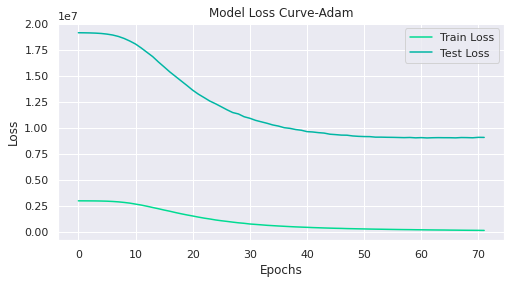

In [ ]:
# visualize model loss functions
model_loss(dnn1, 'Adam')

### Accuracy Metrics

In [ ]:
# get predictions for all 3 dnn models
yhat_dnn1 = model1.predict(testX).reshape(-1)
yhat_dnn2 = model2.predict(testX).reshape(-1)
yhat_dnn3 = model3.predict(testX).reshape(-1)

In [ ]:
# get the metrics for all 3 Deep learning models
dnn1_metrics = get_metrics(ytest, yhat_dnn1, 'Deep Learning 1')
dnn3_metrics = get_metrics(ytest, yhat_dnn3, 'Deep Learning 3')

# append all 3 metrics together
dnn_metrics = dnn1_metrics.append(dnn3_metrics)

In [ ]:
dnn_metrics

,Mean Absolute Error,Root Mean Squared Error,Mean Absolute Percentage Error,R2 Score,MDA Score,Theils U2
Deep Learning 1,2480.636590,3010.797248,0.733976,0.524107,0.818182,0.664464
Deep Learning 3,3598.788107,4025.484655,0.920446,0.149287,0.727273,1.013718


In [ ]:
   # define a prediction plot generator
   def prediction_plot(testY, test_predict, model):
      len_prediction=[x for x in range(len(testY))]
      plt.figure(figsize=(16,4))
      plt.plot(len_prediction, testY, marker='.', label="actual")
      plt.plot(len_prediction, test_predict, 'r', label="prediction")
      plt.tight_layout()
      sns.despine(top=True)
      plt.subplots_adjust(left=0.07)
      plt.ylabel('Tourist Arrivals - India', size=15)
      plt.xlabel('Time step', size=15)
      plt.legend(fontsize=15)
      plt.title(model, fontsize=20)
      plt.show();

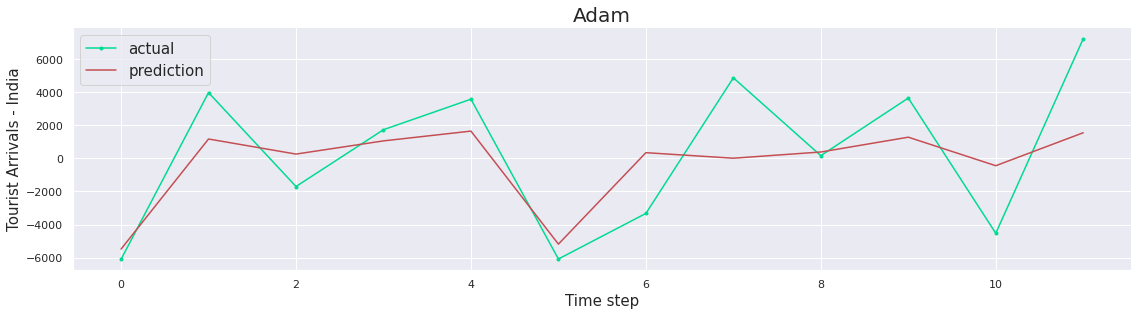

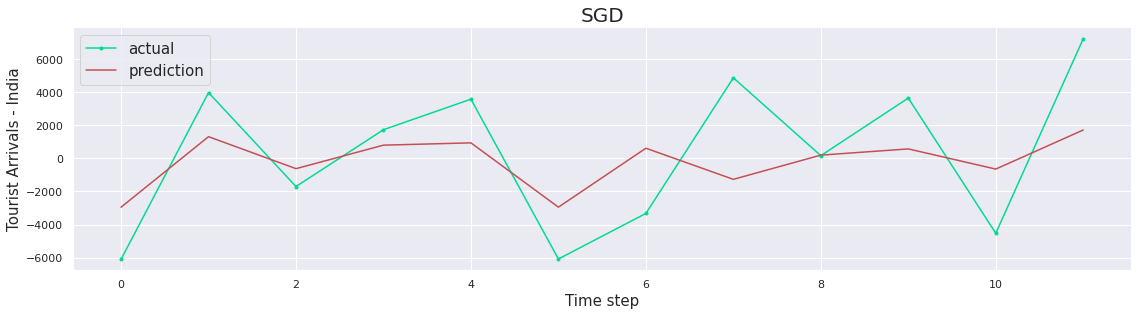

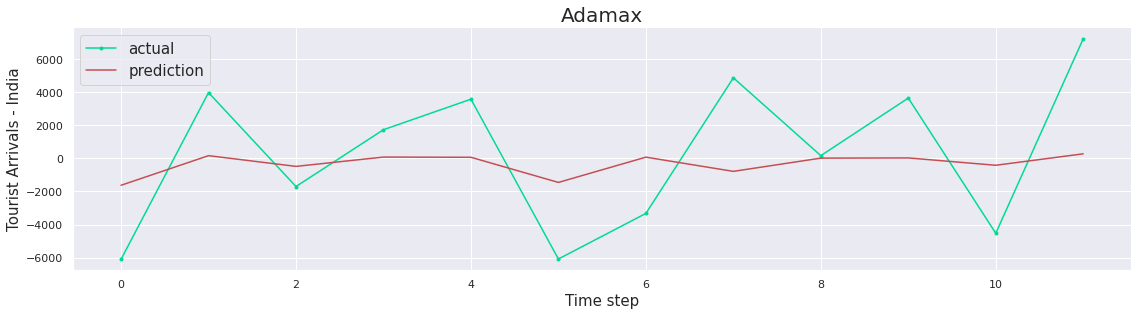

In [ ]:
# i can probably just use the same prediction plots i had set up for the other ML models
prediction_plot(ytest, yhat_dnn1, 'Adam')
prediction_plot(ytest, yhat_dnn2, 'SGD')
prediction_plot(ytest, yhat_dnn3, 'Adamax')

## LSTM

First things first in LSTM. They do not take the typical data structure we input in a normal deep learning network. Whilst we would normally put in input matrices that each stand for one observation, the LSTM requires samples of whole observations (the samples should be made up of a sequential time-window)

In [ ]:
# implementing this code on the already tensored data seems to work
# this is simply just the reshaping of the dataset using numpy.
trainX = np.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = np.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

In [ ]:
#trainbatch=(np.reshape(trainX, (34, 4, 177)))
#ytrainbatch = ytrain[::4]

#testbatch=(np.reshape(testX, (4, 7, 177)))
#ytestbatch = ytest[::7]

In [ ]:
from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout
from keras.callbacks import EarlyStopping
def model_lstm(look_back):
    model=Sequential()
    model.add(LSTM(units=input_dim, input_shape=(1, look_back), activation='relu'))
  # the stateful argument might replicate sequential data passing even when we have 1 sample here))
    model.add(Dropout(0.1))
    model.add(Dense(1))
    model.compile(loss='mean_squared_error',  optimizer='adam',metrics = ['mse', 'mae'])
    return model

look_back = input_dim
model=model_lstm(look_back)

In [ ]:
history = model.fit(trainX, ytrain, epochs=600, batch_size=4, validation_data=(testX, ytest),
                    callbacks=[EarlyStopping(monitor='val_loss', patience=10)], verbose=1, shuffle=False)

Epoch 1/600
42/42 [==============================] - 2s 10ms/step - loss: 2968074.0000 - mse: 2968074.0000 - mae: 1066.5405 - val_loss: 19127170.0000 - val_mse: 19127170.0000 - val_mae: 3910.9463
Epoch 2/600
42/42 [==============================] - 0s 4ms/step - loss: 2966209.2500 - mse: 2966209.2500 - mae: 1065.9745 - val_loss: 19119480.0000 - val_mse: 19119480.0000 - val_mae: 3910.2507
Epoch 3/600
42/42 [==============================] - 0s 4ms/step - loss: 2962565.0000 - mse: 2962565.0000 - mae: 1065.0758 - val_loss: 19103158.0000 - val_mse: 19103158.0000 - val_mae: 3908.7781
Epoch 4/600
42/42 [==============================] - 0s 4ms/step - loss: 2955231.0000 - mse: 2955231.0000 - mae: 1063.3018 - val_loss: 19073150.0000 - val_mse: 19073150.0000 - val_mae: 3906.0701
Epoch 5/600
42/42 [==============================] - 0s 5ms/step - loss: 2942590.0000 - mse: 2942590.0000 - mae: 1059.9747 - val_loss: 19026982.0000 - val_mse: 19026982.0000 - val_mae: 3901.8652
Epoch 6/600
42/42 [=====

Next create the 3d shape of the data we need

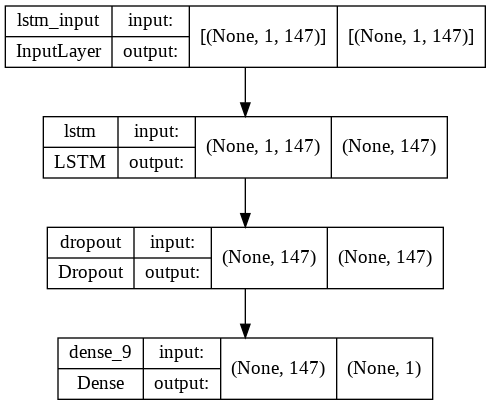

In [ ]:
plot_model(model, to_file='model.png', show_shapes=True, show_layer_names=True)

In [ ]:
yhat_lstm = model.predict(testX).reshape(-1)

In [ ]:
lstm_metrics = get_metrics(ytest, yhat_lstm, 'LSTM Model')

In [ ]:
lstm_metrics

,Mean Absolute Error,Root Mean Squared Error,Mean Absolute Percentage Error,R2 Score,MDA Score,Theils U2
LSTM Model,2423.212956,3092.98414,0.622176,0.497771,0.818182,0.736613


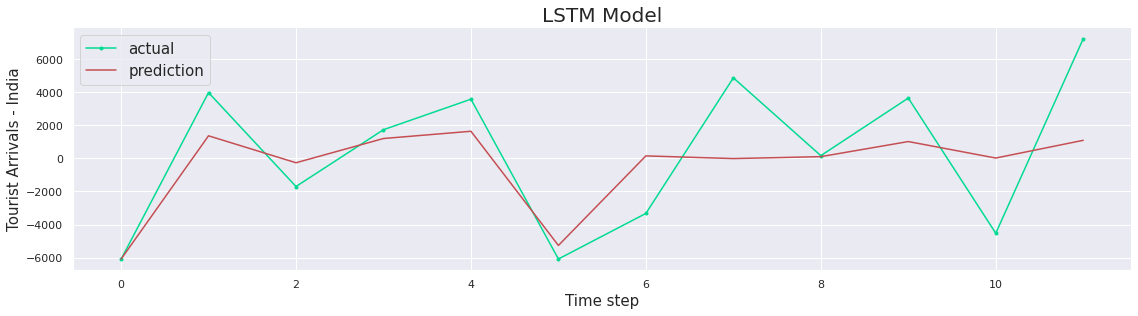

In [ ]:
prediction_plot(ytest, yhat_lstm, 'LSTM Model')

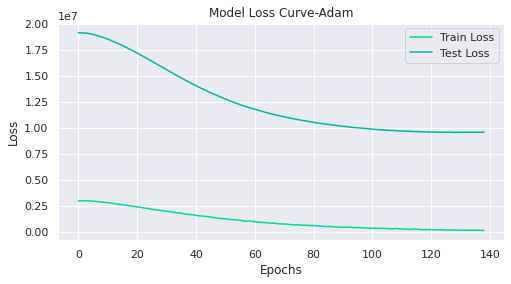

In [ ]:
model_loss(history, 'Adam')

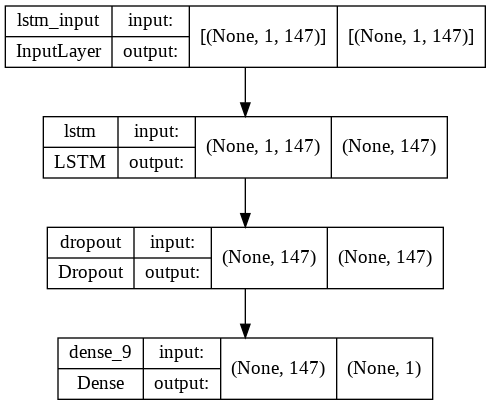

In [ ]:
plot_model(model, to_file='model_plot.png', show_shapes=True, show_layer_names=True)

## Save and Output all Errors

In [ ]:
# aggregate all metrics
metrics = mlerrors.append([dnn_metrics, lstm_metrics])

metrics

,Mean Absolute Error,Root Mean Squared Error,Mean Absolute Percentage Error,R2 Score,MDA Score,Theils U2
Support Vector Regression,3207.935399,3611.332711,0.905077,0.315330,0.909091,0.749183
Random Forest,2667.509167,3073.709855,1.151987,0.504011,1.000000,0.676907
XG Boost,2238.298513,2576.296952,1.054118,0.651552,1.000000,0.605417
Deep Learning 1,2480.636590,3010.797248,0.733976,0.524107,0.818182,0.664464
Deep Learning 3,3598.788107,4025.484655,0.920446,0.149287,0.727273,1.013718
LSTM Model,2423.212956,3092.984140,0.622176,0.497771,0.818182,0.736613


In [ ]:
metrics.sort_values(by='Root Mean Squared Error', ascending=True)

,Mean Absolute Error,Root Mean Squared Error,Mean Absolute Percentage Error,R2 Score,MDA Score,Theils U2
XG Boost,2238.298513,2576.296952,1.054118,0.651552,1.000000,0.605417
Deep Learning 1,2480.636590,3010.797248,0.733976,0.524107,0.818182,0.664464
Random Forest,2667.509167,3073.709855,1.151987,0.504011,1.000000,0.676907
LSTM Model,2423.212956,3092.984140,0.622176,0.497771,0.818182,0.736613
Support Vector Regression,3207.935399,3611.332711,0.905077,0.315330,0.909091,0.749183
Deep Learning 3,3598.788107,4025.484655,0.920446,0.149287,0.727273,1.013718


In [ ]:
all_predictions = pd.DataFrame({'Actual': np.array(ytest), 
                                'Support Vector Regression':yhat_svr,
                                "Random Forest":yhat_rf,
                                "XG Boost": yhat_xgb,
                                "LSTM Network": yhat_lstm},
                               
                               index=index_vals)

In [ ]:
all_predictions

,Actual,Support Vector Regression,Random Forest,XG Boost,LSTM Network
Date,,,,,
2019-01-01,-6097.0,-1963.777340,-4910.91,-3916.372314,-6088.721680
2019-02-01,3978.0,1091.746423,1490.74,2348.701660,1366.766357
2019-03-01,-1699.0,-316.913805,487.35,-1519.667969,-262.816254
2019-04-01,1735.0,740.145650,1212.55,1210.939453,1202.536499
2019-05-01,3579.0,896.542137,1860.75,1669.213135,1640.915894
2019-06-01,-6080.0,-1878.318268,-3918.09,-4186.526367,-5261.671387
2019-07-01,-3326.0,495.429025,960.69,235.983337,152.020233
2019-08-01,4872.0,48.418578,1328.32,1098.542603,-10.080012
2019-09-01,166.0,-157.344766,1168.98,-964.557922,106.578896


Text(0.5, 1.0, 'Predictions vs Actual Arrivals')

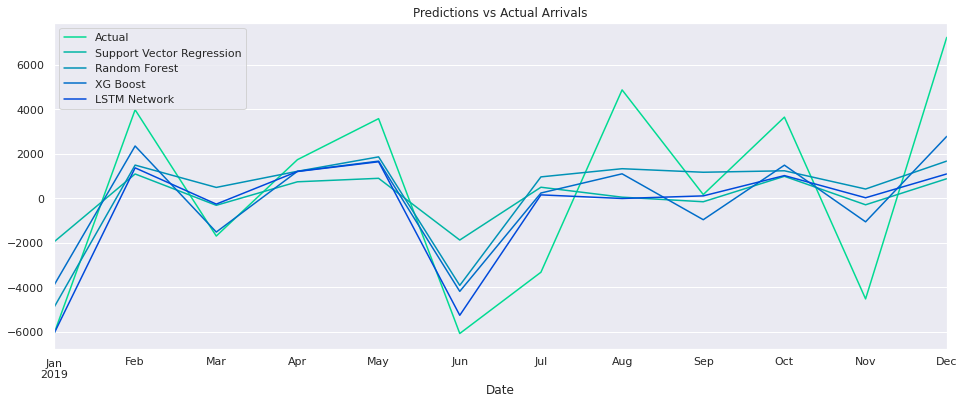

In [ ]:
ax = all_predictions.plot(figsize=(16,6))
ax.set_title('Predictions vs Actual Arrivals')

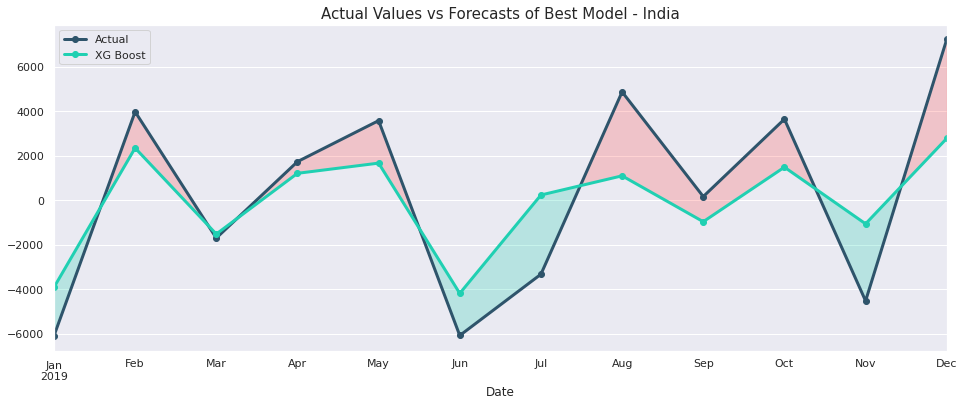

In [ ]:
ax = all_predictions[['Actual', 'XG Boost']].plot(figsize=(16,6), color=('#2e546b', '#20d0b2'),
                                                  linewidth=3, marker='o')
ax.set_title('Actual Values vs Forecasts of Best Model - India', fontsize=15)


ax.fill_between(all_predictions.index, all_predictions['Actual'], all_predictions['XG Boost'], 
                where=(all_predictions['Actual'] < all_predictions['XG Boost']),
                interpolate=True, color="#20d0b2", alpha=0.25)


ax.fill_between(all_predictions.index, all_predictions['Actual'], all_predictions['XG Boost'], 
                where=(all_predictions['Actual'] >= all_predictions['XG Boost']),
                interpolate=True, color="#ff5050", alpha=0.25)

## Post Covid model evaluation

In [ ]:
# first import the new files

gtrend = pd.read_excel('/content/gdrive/My Drive/Datasets/India-Gtrend.xlsx')
df = pd.read_excel('/content/gdrive/My Drive/Datasets/Arrivals.xlsx')

# set the correct date time format
df['Date'] = pd.to_datetime(df['Date'], format="%d/%m/%Y")
gtrend['Month'] = pd.to_datetime(gtrend['Month'], format='%Y-%m')

# set date as the index
df.set_index("Date", inplace=True)
gtrend.set_index('Month', inplace=True)



In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 220 entries, 2004-01-01 to 2022-04-01
Data columns (total 4 columns):
 #   Column                  Non-Null Count  Dtype
---  ------                  --------------  -----
 0   Total tourist arrivals  220 non-null    int64
 1   Italy                   220 non-null    int64
 2   Germany                 220 non-null    int64
 3   India                   220 non-null    int64
dtypes: int64(4)
memory usage: 8.6 KB


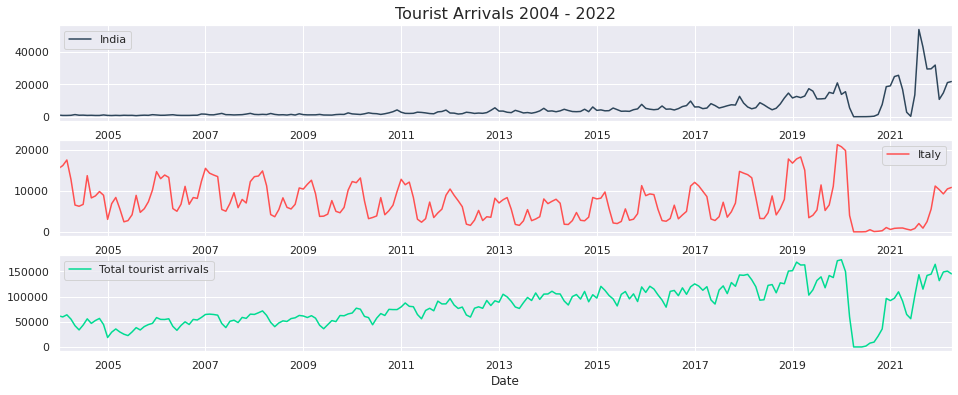

In [ ]:
plt.subplot(311)
ax = df['India'].plot(figsize=(16, 6), legend=True, color='#2e465b')

# change title parameters
ax.set_title('Tourist Arrivals 2004 - 2022', fontsize=16) # set the title

plt.subplot(312)
ax = df['Italy'].plot(figsize=(16, 6), legend=True, color='#ff5050')
plt.subplot(313)
ax = df['Total tourist arrivals'].plot(figsize=(16, 6), legend=True)


In [ ]:
# we will be using this same set of code for all of the various countries

# specify the country i need
country = 'India'

# drop any columns not in country
for column in df:
    if column not in country:
        del df[column]

# join the two files on the index
main_df = df.join(gtrend)

In [ ]:
#create an empty dataframe to add our lagged variables (X train set)

lagged = pd.DataFrame()  

# take Italy values to train target
target = main_df['India'].values


number_lags = 12
for lag in range(1, number_lags + 1):
  for column in main_df:
    lagged[str(column) + 'lag' + str(lag)] = main_df[column].shift(lag)


# copy into a new dataframe to get a de-fragmented newframe
lagged = lagged.copy()

# add the non-lagged target value back into the dataframe
lagged['India'] = target

# drop na variables in the lagtrend
lagged.dropna(inplace=True)

In [ ]:
# to induce stationarity, we will do differencing for the whole dataset 
lag_diff = lagged.diff()

# differencing creates a missing number in the first row - so we'll need to remove the first na row
lag_diff.dropna(inplace=True)

In [ ]:
# next split the data set into the train and testing sets
# division of sequence is done so as to leave 1 year for the testset
postcovid = lag_diff.iloc[191:,:]


# might be worth looking into the different validation set splitting methods, in the deep learning file?

In [ ]:
postcovid.head()

,Indialag1,best resort in maldiveslag1,flights to maldiveslag1,honeymoon packages in maldiveslag1,maldives airportlag1,maldives beachlag1,maldives family triplag1,maldives honeymoonlag1,maldives hotelslag1,maldives resortlag1,...,maldives hotelslag12,maldives resortlag12,maldives visalag12,maldives water villalag12,maldives weatherlag12,male maldiveslag12,mumbai to maldiveslag12,sun island resort maldiveslag12,delhi to maldives flightlag12,India
Date,,,,,,,,,,,,,,,,,,,,,
2021-01-01,11028.0,23.0,-2.0,1.0,6.0,5.0,6.0,-2.0,4.0,5.0,...,-2.0,-7.0,-4.0,-9.0,-5.0,0.0,-6.0,1.0,0.0,498.0
2021-02-01,498.0,-5.0,0.0,3.0,-2.0,1.0,8.0,0.0,1.0,3.0,...,-1.0,4.0,-5.0,15.0,-2.0,-1.0,-8.0,11.0,-3.0,5770.0
2021-03-01,5770.0,-8.0,-1.0,-9.0,7.0,-2.0,-17.0,-8.0,-7.0,1.0,...,-3.0,-19.0,-10.0,-37.0,-22.0,-9.0,-18.0,-12.0,-11.0,785.0
2021-04-01,785.0,-9.0,-2.0,7.0,-10.0,-1.0,-2.0,4.0,1.0,-6.0,...,1.0,-4.0,-3.0,9.0,-6.0,-2.0,-2.0,-6.0,-7.0,-8772.0
2021-05-01,-8772.0,-14.0,3.0,-13.0,-3.0,-5.0,1.0,-12.0,-1.0,-14.0,...,-2.0,-6.0,-5.0,-15.0,3.0,2.0,-3.0,-2.0,-5.0,-14142.0


In [ ]:
# we do the same for the testset dataset
postcovid['month'] = postcovid.index.month

# take the index into a seperate variable for now
index_vals = postcovid.index

high_season = [12, 1, 2, 3, 4, 5]

postcovid['high_season'] = postcovid['month'].apply(lambda x: 1 if x in high_season else 0)

In [ ]:
stop

NameError: ignored

In [ ]:
# import the onehotencoder class to implement encoding
from sklearn.preprocessing import OneHotEncoder


# set aside the categorical columns as a list object 
catcols = ['month']

# define the get dummies function to return encoded train and test sets
def get_dummies(testset, old_col_name):
    """Given a trainset, a testset, and the name of a column holding a 
    categorical variable, fit an encoder on the trainset, and use the 
    encoder to add dummy columns into the trainset and testset
    """
    
    one_hot_encoder = OneHotEncoder(drop="first", sparse=False)
    
    # the input to the encoder must be a 2-d numpy array,
    # so we take the column, extract their values and reshape the array to be 2-d
    # the old_col_name will be taken from the categorical columns list defined previously
    cat_vals = postcovid[old_col_name].values.reshape(-1,1)

    # fit an encoder and transform the **trainset**
    # the output is a new numpy array
    transformed = one_hot_encoder.fit_transform(cat_vals)
    
    # in the list of new columns, convert numpy array to a list and
    # drop the first column, because we requested "drop='first'"
    new_col_names = one_hot_encoder.categories_[0].tolist()[1:]
    
    for i, new_col_name in enumerate(new_col_names):
        
        # put the transformed data as columns in the trainset dataframe
        testset[new_col_name] = transformed[:,i]
    
    return testset


for col_name in catcols:
    postcovid = get_dummies(postcovid, col_name)

In [ ]:
# now that we have our dummy variables in place, we no longer need the old month column which we'll drop


del postcovid['month']

Usee the same fitted scaler from the original trainset to transform this testset

In [ ]:
# take the target (Italy) out before we scale
postcovid_target = postcovid["India"].values

# take predictors as seperate dataframe
postcovid_predictors = postcovid.drop(columns=["India"], axis=1)

# call the fit and transform method on our predictors
scaled_vals = scaler.transform(postcovid_predictors)

# put the scaled values back into the trainset dataframe
postcovid = pd.DataFrame(scaled_vals, columns=postcovid_predictors.columns)

# put the target back in
postcovid['India'] = postcovid_target


# inspect the data
postcovid.head()

Before splitting into X and y i'll need to remove the same columns removed in the MIC part

In [ ]:
# split the target and the non-targets into X and Y sets


ycov = postcovid['India'].copy()

# take the predictors to the X
Xcov = postcovid.drop('India', axis=1)

In [ ]:
# use the previously built function to remove the columns
col_list = to_remove.index.tolist()

Xcov = remove_cols(Xcov)

I'll also need to reshape the X into a tensor to fit into the LSTM model

In [ ]:
# convert the Xcov fit for the LSTM model
covX = tf.convert_to_tensor(Xcov)
covX = np.reshape(covX, (covX.shape[0], 1, covX.shape[1]))

Now that we have everything we can evaluate the dataset

In [ ]:
# get the predictions
yhat_xgb_cov = best_xgb.predict(Xcov)
yhat_rf_cov = best_rf.predict(Xcov)
yhat_lstm_cov = model.predict(covX).reshape(-1)

# save the metrics 
cov_xgb_metrics = get_metrics(ycov, yhat_xgb, 'XG Boost')
cov_rf_metrics = get_metrics(ycov, yhat_rf, 'RF Metrics')
cov_lstm_metrics = get_metrics(ycov, yhat_lstm, 'LSTM Model')

Now append the results of the metrics into one dataframe

In [ ]:
# create dataframe with error metrics
postcov_predictions = pd.DataFrame({'Actual': np.array(ycov),
                                "Random Forest":yhat_rf_cov,
                                "XG Boost": yhat_xgb_cov,
                                "LSTM Network": yhat_lstm_cov})

In [ ]:
postcov_predictions

In [ ]:
postcov_metrics = cov_xgb_metrics.append([cov_rf_metrics, cov_lstm_metrics])

In [ ]:
postcov_metrics

In [ ]:
ax = postcov_predictions.plot(figsize=(16,6))
ax.set_title('Post Covid prediction accuracy')

In [ ]:
ax = postcov_predictions[['Actual', 'XG Boost']].plot(figsize=(16,6), color=('#2e546b', '#20d0b2'),
                                                  linewidth=3, marker='o')
ax.set_title('Actual Values vs Forecasts of Best Model - India', fontsize=15)


ax.fill_between(postcov_predictions.index, postcov_predictions['Actual'], postcov_predictions['XG Boost'], 
                where=(postcov_predictions['Actual'] < postcov_predictions['XG Boost']),
                interpolate=True, color="#20d0b2", alpha=0.25)


ax.fill_between(postcov_predictions.index, postcov_predictions['Actual'], postcov_predictions['XG Boost'], 
                where=(postcov_predictions['Actual'] >= postcov_predictions['XG Boost']),
                interpolate=True, color="#ff5050", alpha=0.25)